In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
# import bbknn
sc.logging.print_versions()

scanpy==1.3.7 anndata==0.6.17 numpy==1.16.0 scipy==1.2.0 pandas==0.24.0 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Import tabula-muris (3m)

In [1]:
# maca10x3metadata = pd.read_csv('/data/maca/data/10x/MACA_10x.csv',usecols = ['channel','tissue','tissue.notes','mouse.age','mouse.sex','pool'])
maca10x3metadata2 = pd.read_csv('/data/maca/data/10x/MACA_10x_1_3_30.csv',usecols = ['channel','tissue','tissue.notes','mouse.age','mouse.sex','pool','mouse.id'])
tm_droplet_metadata = pd.read_csv('/data/maca/data/10x/TM_droplet_metadata.csv', low_memory=False,
                               usecols = ['cell','tissue','subtissue','mouse.sex','mouse.id','method','cell_ontology_class','cell_ontology_id','free_annotation'])

maca10x3metadata2 = maca10x3metadata2.rename(columns = {'mouse.age':'age','mouse.sex':'sex','tissue.notes':'subtissue'})
tm_droplet_metadata = tm_droplet_metadata.rename(columns = {'mouse.sex':'sex'})
display(tm_droplet_metadata.head())
tm_droplet_metadata['cell_index'] = tm_droplet_metadata['cell']
tm_droplet_metadata = tm_droplet_metadata.set_index('cell_index')
tm_droplet_metadata.tail()

In [ ]:
tm_droplet_data = read_h5ad('/data/maca/data/10x/TM_droplet_mat.h5ad')
tm_droplet_data

In [ ]:
tm_droplet_data.obs = tm_droplet_metadata
tm_droplet_data.obs['age'] = '3m'

tm_droplet_data.obs['sex'] = tm_droplet_data.obs['sex'].replace({'M':'male', 'F':'female'})
tm_droplet_data.obs.head()

In [ ]:
tm_droplet_data

## Create droplet data object for all ages but 3m

### 18, 21 and 24 months

In [ ]:
path = '/data/maca/data/'
maca10x182124metadata = pd.read_csv('/data/maca/data/MACA_10x_18-21-24_qc.csv',usecols = ['channel','tissue','tissue.notes','mouse.age','mouse.sex','mouse.id'])

maca10x182124metadata = maca10x182124metadata.rename(columns = {'mouse.age':'age','mouse.sex':'sex','tissue.notes':'subtissue'})
maca10x182124metadata.index = range(len(maca10x182124metadata))
maca10x182124metadata['mouseID'] = maca10x182124metadata['age'].apply(str)+'-'+maca10x182124metadata['sex']+'-'+maca10x182124metadata['mouse.id'].apply(str)


In [ ]:
maca10x182124metadata.head()

In [ ]:
adata182124aux = []
for i in range(0,len(maca10x182124metadata)):
    path = '/data/maca/data/' + maca10x182124metadata.channel[i] + '/'
    foo = sc.read(path + 'matrix.mtx', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'genes.tsv', dtype=str)[:, 1]
    foo.obs_names = np.genfromtxt(path + 'barcodes.tsv', dtype=str)
    foo.obs['tissue'] = str(maca10x182124metadata.tissue[i]).title()
    #foo.obs['subTissue'] = str(maca10x182124metadata.subtissue[i]).title()
    
    
    if pd.isnull(maca10x182124metadata.subtissue[i]):
        foo.obs['subtissue'] = maca10x182124metadata.subtissue[i]
    else:        
        foo.obs['subtissue'] = str(maca10x182124metadata.subtissue[i]).title()
        
    
    foo.obs['age'] = str(maca10x182124metadata.age[i]) + 'm'
    
    if maca10x182124metadata.sex[i] == 'M':
        foo.obs['sex'] = 'male'
    else:
        foo.obs['sex'] = 'female'
    
    if maca10x182124metadata.tissue[i] == 'MUSCLE':
        foo.obs['tissue'] = 'Limb_Muscle'
    
    if maca10x182124metadata.tissue[i] == 'BRAIN':
        foo.obs['tissue'] = 'Brain_Non-Myeloid'
    
    if maca10x182124metadata.tissue[i] == 'MAMMARY':
        foo.obs['tissue'] = 'Mammary_Gland'
        
    foo.obs['cell'] = maca10x182124metadata.channel[i]
    
    foo.obs['mouse.id'] = maca10x182124metadata.mouseID[i]
        
    sc.pp.filter_cells(foo, min_genes=250)
    
    adata182124aux.append(foo)


first = adata182124aux.pop()
adata182124 = first.concatenate(adata182124aux)
adata182124.obs['cell'] = adata182124.obs['cell'] + '_' + adata182124.obs_names
adata182124.obs['cell'] = adata182124.obs['cell'].apply(lambda x: pd.Series(x.split('-')))[0]
adata182124.obs['method'] = 'droplet'
adata182124.obs['cell_ontology_class'] = 'NA'
adata182124.obs['cell_ontology_id'] = 'NA'
adata182124.obs['free_annotation'] = 'NA'

adata182124.obs.head()

In [ ]:
set(adata182124.obs['tissue'])


## 1 and 30months

In [ ]:
path = '/data/maca/data/10x/'
# maca10x3metadata = pd.read_csv('/data/maca/data/10x/MACA_10x.csv',usecols = ['channel','tissue','tissue.notes','mouse.age','mouse.sex','pool'])
maca10x3metadata = pd.read_csv('/data/maca/data/10x/MACA_10x_1_30.csv',usecols = ['channel','tissue','tissue.notes','mouse.age','mouse.sex','mouse.id'])
# maca10x3metadata2 = pd.read_csv('/data/maca/data/10x/TM_droplet_metadata.csv', low_memory=False)

maca10x3metadata = maca10x3metadata.rename(columns = {'mouse.age':'age','mouse.sex':'sex','tissue.notes':'subtissue','mouse.id':'mouseid'})
#maca10x3metadata = maca10x3metadata[maca10x3metadata.age == 3]
maca10x3metadata.index = range(len(maca10x3metadata))

maca10x3metadata.head()

In [ ]:
adata3aux = []
for i in range(0,len(maca10x3metadata)):
    #print(i)
    path = '/data/maca/data/10x/' + maca10x3metadata.channel[i] + '/'
    foo = sc.read(path + 'matrix.mtx', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'genes.tsv', dtype=str)[:, 1]
    foo.obs_names = np.genfromtxt(path + 'barcodes.tsv', dtype=str)
    foo.obs['tissue'] = maca10x3metadata.tissue[i]
    foo.obs['subtissue'] = maca10x3metadata.subtissue[i]
    foo.obs['age'] = str(maca10x3metadata.age[i]) + 'm'
    foo.obs['mouse.id'] = maca10x3metadata.mouseid[i]
    
    if maca10x3metadata.sex[i] == 'M':
        foo.obs['sex'] = 'male'
    else:
        foo.obs['sex'] = 'female'
    
    if maca10x3metadata.tissue[i] == 'Muscle':
        foo.obs['tissue'] = 'Limb_Muscle'
    
    if maca10x3metadata.tissue[i] == 'Colon':
        foo.obs['tissue'] = 'Large_Intestine'
    
    if maca10x3metadata.tissue[i] == 'Brain':
        foo.obs['tissue'] = 'Brain_Non-Myeloid'
    
    if maca10x3metadata.tissue[i] == 'Mammary':
        foo.obs['tissue'] = 'Mammary_Gland'
        
    sc.pp.filter_cells(foo, min_genes=250)
    
    foo.obs['cell'] = maca10x3metadata.channel[i]# + foo.obs_names.split("-")[0]
    
#     foo.obs['cell_ontology_class'] = 'NA' #maca10x3metadata.cell_ontology_class[i]
    #foo.obs['CellTypeID'] = maca10x3metadata.cell_ontology_id[i]
    #foo.obs['FreeAnn'] = maca10x3metadata.free_annotation[i]
    
    adata3aux.append(foo)
    #print(adata3.X.size*8/1000000) # convert to Mb

first = adata3aux.pop()
adata3 = first.concatenate(adata3aux)
adata3.obs['cell'] = adata3.obs['cell'] + '_' + adata3.obs_names
adata3.obs['cell'] = adata3.obs['cell'].apply(lambda x: pd.Series(x.split('-')))[0]
adata3.obs['method'] = 'droplet'
adata3.obs['cell_ontology_class'] = 'NA'
adata3.obs['cell_ontology_id'] = 'NA'
adata3.obs['free_annotation'] = 'NA'
display(adata3.obs.head())
adata3

In [ ]:
set(adata3.obs['tissue'])

## concatenate anndata objs for the new data

In [ ]:
adata118212430 = adata182124.concatenate(adata3)
adata118212430.obs['tissue_free_annotation'] = adata118212430.obs['tissue']
adata118212430.obs['tissue'] = adata118212430.obs['tissue'].replace({'Aorta':'Heart_and_Aorta','Heart':'Heart_and_Aorta'})\

In [ ]:
set(adata118212430.obs['mouse.id'])

In [ ]:
adata118212430.write('./write/maca-droplet-1-18-21-24-30-raw.h5ad')

# Combine all droplet data and write the object

In [ ]:
tm_droplet_data.obs['tissue_free_annotation'] = tm_droplet_data.obs['tissue']
adata = adata118212430.concatenate(tm_droplet_data)

In [ ]:
set(adata.obs['mouse.id'])

In [ ]:
adata.write('./write/maca-droplet-raw-data-all-ages.h5ad')

In [ ]:
import gc
gc.collect()

# Import DROPLET raw data

In [ ]:
pwd

In [88]:
adata = read_h5ad('../anndata-objs/maca-droplet-raw-data-all-ages.h5ad')
adata

AnnData object with n_obs × n_vars = 418908 × 23433 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'

In [89]:
adata.write_loom('./write/maca-droplet-raw.loom')

In [ ]:
adata.shape

In [ ]:
type(adata.X)

In [ ]:
adata.obs.tail()

In [ ]:
set(adata.obs['tissue'])

In [ ]:
set(adata.obs['age'])

In [84]:
tiss = adata[adata.obs['tissue']=='Spleen']
tiss

View of AnnData object with n_obs × n_vars = 46095 × 23433 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'

In [86]:
tiss.write('./write/spleen-raw-data-all-ages.h5ad')

# Preprocessing

In [ ]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=500)
adata

add the total counts per cell as observations-annotation to adata

In [ ]:
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
adata

In [ ]:
adata = adata[adata.obs['n_counts']>=3000]
adata

In [ ]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['age']=='3m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['age']!='3m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?
adata.raw = adata

In [ ]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
adata

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.scale(adata, max_value=10, zero_center=False)

# Exploration

## PCA

In [ ]:
sc.tl.pca(adata,use_highly_variable=True)

In [ ]:
sc.pl.pca_scatter(adata, color=['tissue'])#, save='_all_ages_droplet_facs_tissue.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color=['age'])#, save='_all_ages_droplet_facs_age.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color=['sex'])#, save='_all_ages_droplet_facs_sex.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts')#, save='_all_ages_droplet_facs_counts.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color='method')#, save='_all_ages_droplet_facs_method.pdf')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pl.pca_loadings(adata)

## Louvain clustering

In [ ]:
sc.pp.neighbors(adata, n_neighbors=12)#, method='gauss')
sc.tl.louvain(adata, resolution = 1)

In [ ]:
adata

## UMAP

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'], save='_all_ages_droplet_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['age'], save='_all_ages_droplet_age.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['sex'], save='_all_ages_droplet_sex.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['louvain'], save='_all_ages_droplet_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['cell_ontology_class'], save='cell_ontology_class.pdf')

## tSNE

In [ ]:
sc.tl.tsne(adata, perplexity=50)

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(adata, color=['tissue'], save='_all_ages_droplet_tissue.pdf')

In [ ]:
sc.pl.tsne(adata, color=['age'], save='_all_ages_droplet_age.pdf')

In [ ]:
sc.pl.tsne(adata, color=['sex'], save='_all_ages_droplet_sex.pdf')

In [ ]:
sc.pl.tsne(adata, color=['cell_ontology_class'], save='cell_ontology_class.pdf')

In [ ]:
sc.pl.tsne(adata, color=['louvain'], save='_all_ages_droplet_louvain.pdf')

# Write pre-processed object

In [ ]:
adata.write('./write/maca-droplet-pre-processed.h5ad')

In [ ]:
adata

# Loop through all tissues

In [3]:
adata = read_h5ad('../anndata-objs/maca-droplet-pre-processed.h5ad')

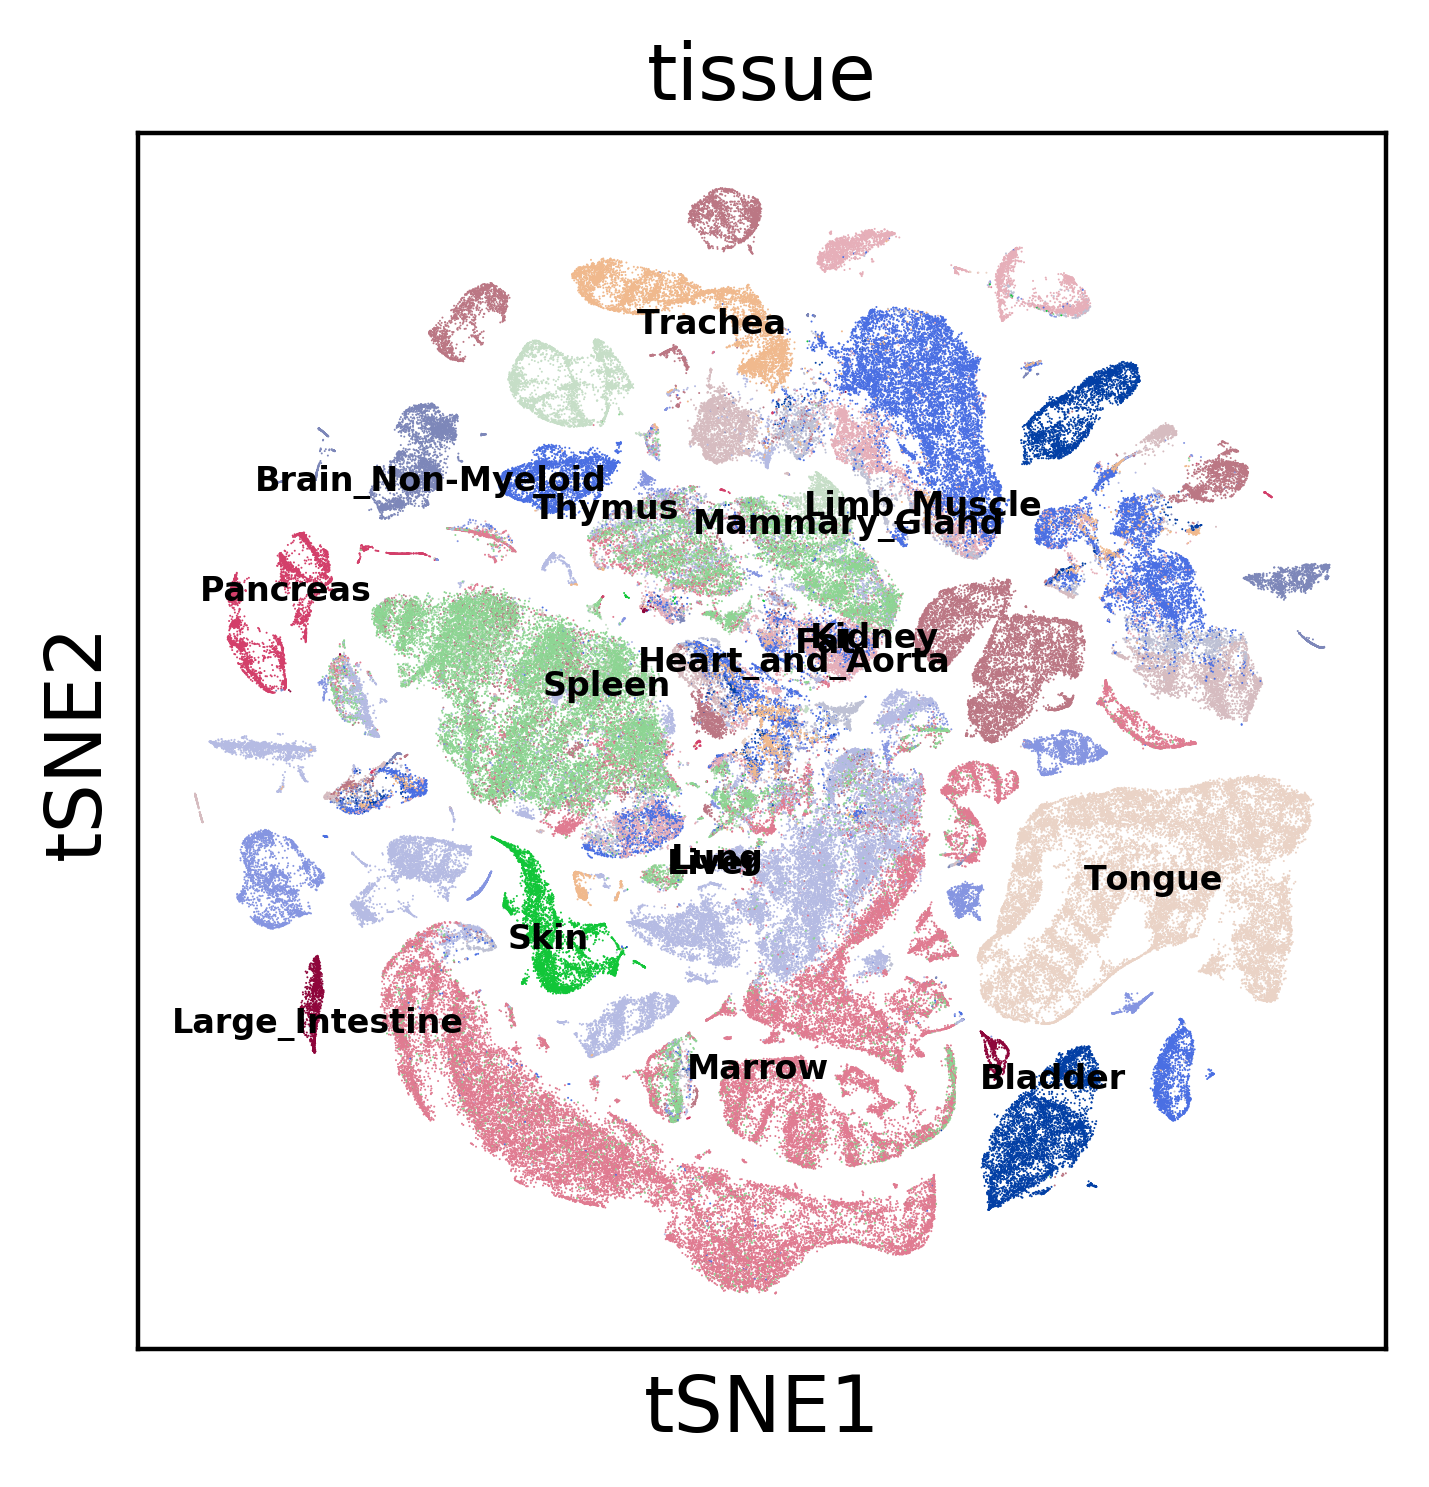

In [4]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(adata, color=['tissue'],legend_loc='on data',legend_fontsize=6)

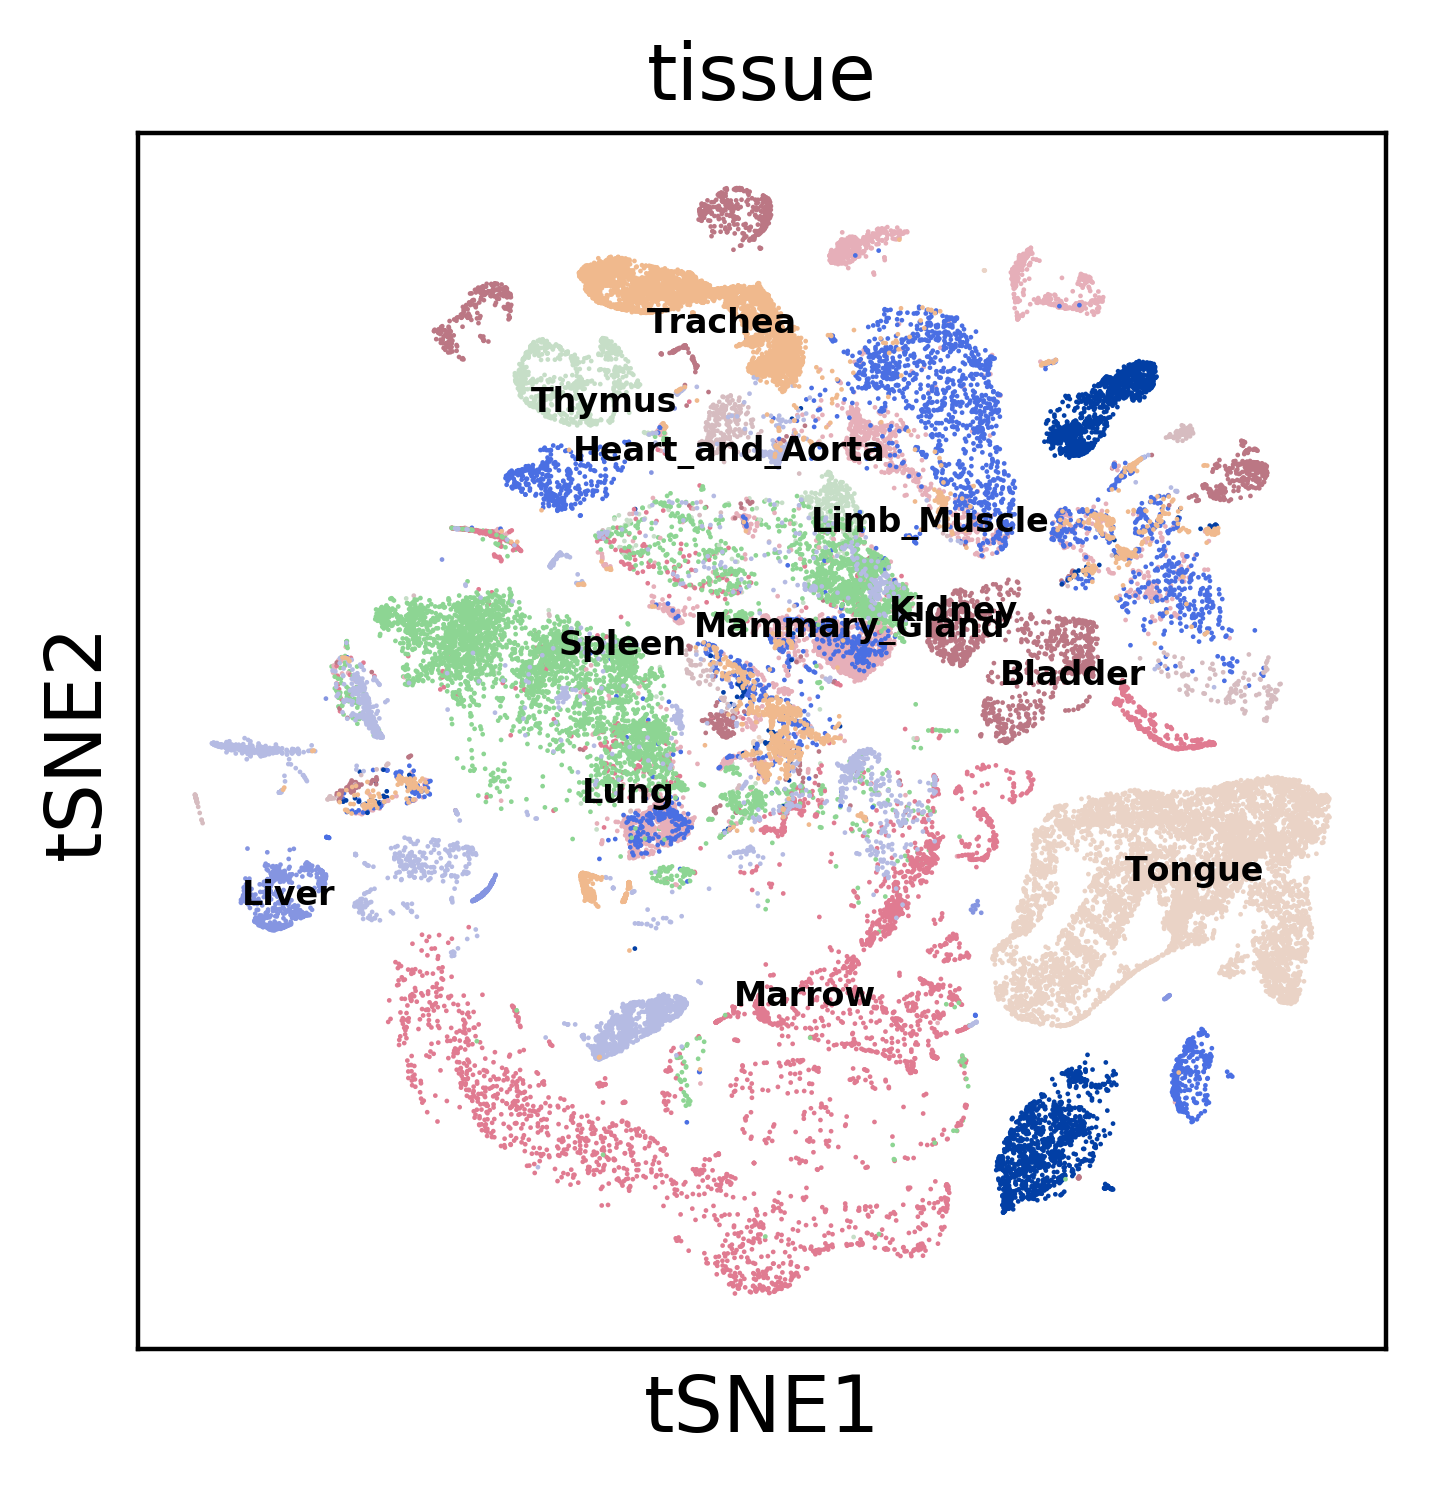

In [5]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(adata[adata.obs['age']=='3m'], color=['tissue'],legend_loc='on data',legend_fontsize=6)

In [6]:
adata

AnnData object with n_obs × n_vars = 235325 × 19860 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'sex_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [ ]:
auto_annotation_fractions = {}

In [8]:
tissues_available = list(set(adata.obs['tissue']))
tissues_available.sort()
pd.DataFrame(tissues_available,columns=['Tissues'])

Tissues
0             Bladder
1   Brain_Non-Myeloid
2                 Fat
3     Heart_and_Aorta
4              Kidney
5     Large_Intestine
6         Limb_Muscle
7               Liver
8                Lung
9       Mammary_Gland
10             Marrow
11           Pancreas
12               Skin
13             Spleen
14             Thymus
15             Tongue
16            Trachea

In [9]:
tissofinterest = tissues_available[8]
tiss = adata[adata.obs['tissue'] == tissofinterest,:]

In [ ]:
auto_annotation_fractions

In [ ]:
len(set(tiss.obs['cell_ontology_class']))

In [ ]:
set(tiss.obs['age'])

In [10]:
tiss

View of AnnData object with n_obs × n_vars = 27757 × 19860 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'sex_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

# Fast tissue object generation

In [ ]:
n = 15
tissues_available = tissues_available[n:]
tissues_available

In [ ]:
for tissofinterest in tissues_available:
    print('here we go again!!!')
    print(tissofinterest)
    tiss = adata[adata.obs['tissue'] == tissofinterest,:]
    
    print('pca')
    sc.tl.pca(tiss)
    
    print('neighs & louvain')
    sc.pp.neighbors(tiss, n_neighbors=12)
    sc.tl.louvain(tiss, resolution = .7)
    
    print('umap computing')
    sc.tl.umap(tiss)
#     sc.settings.set_figure_params(dpi=200)
    try:
        sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
    except IndexError:
        tiss.obs['subtissue'] = 'NA'
        sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['age','mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
    
    print('tsne computing')
    sc.tl.tsne(tiss, perplexity=50)
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['method'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    
    print('comparing to 3m data')
    ageofinterest = '3m'
    tissage = tiss[tiss.obs['age'] == ageofinterest,:]
    tissage
#     sc.pl.tsne(tissage, color=['cell_ontology_class','louvain'])
#     sc.pl.umap(tissage, color=['cell_ontology_class','louvain'])
#     sc.pl.umap(tissage, color=['cell_ontology_class','age'])
    tiss_cell_ontology_class = {}
    for i in set(tissage.obs['louvain']):
        df = tissage.obs[tissage.obs['louvain']==i]['cell_ontology_class']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['cell_ontology_class']]
        if a.empty:
            tiss_cell_ontology_class[i] = 'tbc'
        else:
            tiss_cell_ontology_class[i] = a.values[0][0]

    tiss_cell_ontology_class
    display(set(tiss_cell_ontology_class.values()))
    display(set(tissage.obs['cell_ontology_class']))

    set(tiss.obs['cell_ontology_class'])
    tiss_free_annotation = {}
    for i in set(tissage.obs['louvain']):
        df = tissage.obs[tissage.obs['louvain']==i]['free_annotation']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('free_annotation').count()/df.groupby('free_annotation').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['free_annotation']]
        if a.empty:
            tiss_free_annotation[i] = 'nan'
        else:
            tiss_free_annotation[i] = a.values[0][0]

    tiss_free_annotation
    display(set(tiss_free_annotation.values()))
    set(tiss.obs['free_annotation'])
    new_populations = {}
    if set(tissage.obs['louvain']) != set(tiss.obs['louvain']):
        new_clusters = list(set(tiss.obs['louvain']) - set(tissage.obs['louvain']))
        for i in range(0,len(new_clusters)):
            new_populations[new_clusters[i]] = 'new-cluster'
        print(new_populations)
        tiss_cell_ontology_class = {**tiss_cell_ontology_class, **new_populations}
        tiss_free_annotation = {**tiss_free_annotation, **new_populations}

    new_populations_ages = {}
    j = 0
    print(tissofinterest)
    for i in new_populations.keys():
        j=j+1
        print(i, set(tiss.obs['age'][tiss.obs['louvain']==i]))
        new_populations_ages[j,1] = i
        new_populations_ages[j,2] = set(tiss.obs['age'][tiss.obs['louvain']==i])

    new_populations_ages
    
    print('mapping new annotations')
    tiss.obs['auto_cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)
    set(tiss.obs['auto_cell_ontology_class'])
    tiss.obs['auto_free_annotation'] = tiss.obs['louvain'].map(tiss_free_annotation)
    set(tiss.obs['auto_free_annotation'])
    tiss.obs['cluster_names'] = tiss.obs['louvain'].astype(str)+'_'+tiss.obs['auto_cell_ontology_class'].astype(str)
    print(set(tiss.obs['cluster_names']))
    print('saving graphical outputs')
#     sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])
    sc.pl.tsne(tiss, color=['cell_ontology_class','auto_cell_ontology_class'],
               save='_'+ str(tissofinterest) +'_all_ages_droplet_cell_ontology_class_with_auto.pdf')
#     sc.pl.tsne(tiss, color=['free_annotation','auto_free_annotation'])
#     sc.pl.tsne(tiss, color=['age','free_annotation'])
    sc.pl.tsne(tiss, color=['age','auto_cell_ontology_class'],
               save='_' + str(tissofinterest) + '_all-ages_droplet_auto_cell_ontology_class_age.pdf')
    sc.pl.tsne(tiss, color=['age','cell_ontology_class'],
               save='_' + str(tissofinterest) + '_all-ages_droplet_cell_ontology_class_age.pdf')
    sc.pl.tsne(tiss, color=['cluster_names'],
               save='_' + str(tissofinterest) + '_all-ages_droplet_cluster_names.pdf')
    sc.pl.umap(tiss, color=['age','louvain'],
               save='_' + str(tissofinterest) + '_all-ages_droplet_louvain_age.pdf')
#     sc.pl.tsne(tiss[tiss.obs['auto_cell_ontology_class']=='tbc'],color = ['cell_ontology_class','louvain'])
    
    print('computing ranking genes')
    sc.tl.rank_genes_groups(tiss, 'cluster_names')#,penalty='l1')
#     sc.pl.rank_genes_groups(tiss, n_genes=20)
    
    print('saving object')
    tiss.write('./write/'+tissofinterest+'_droplet_processed.h5ad')

In [ ]:
tiss_cell_ontology_class = {}
tiss_cell_ontology_class['1'] = 'name1'

tiss_cell_ontology_class['2'] = 'name1'
tiss.obs['Tal_cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)

# Tissue Preprocessing

In [12]:
set(tiss.obs['subtissue'])

{'LUNG', 'immune-endo-depleted', nan}

In [13]:
sc.pp.filter_genes(tiss, min_cells=5)
sc.pp.filter_cells(tiss, min_genes=250)
tiss

AnnData object with n_obs × n_vars = 27757 × 16831 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'sex_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

add the total counts per cell as observations-annotation to adata

In [14]:
tiss.obs['n_counts'] = np.sum(tiss.X, axis=1).A1
tiss

AnnData object with n_obs × n_vars = 27757 × 16831 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'sex_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

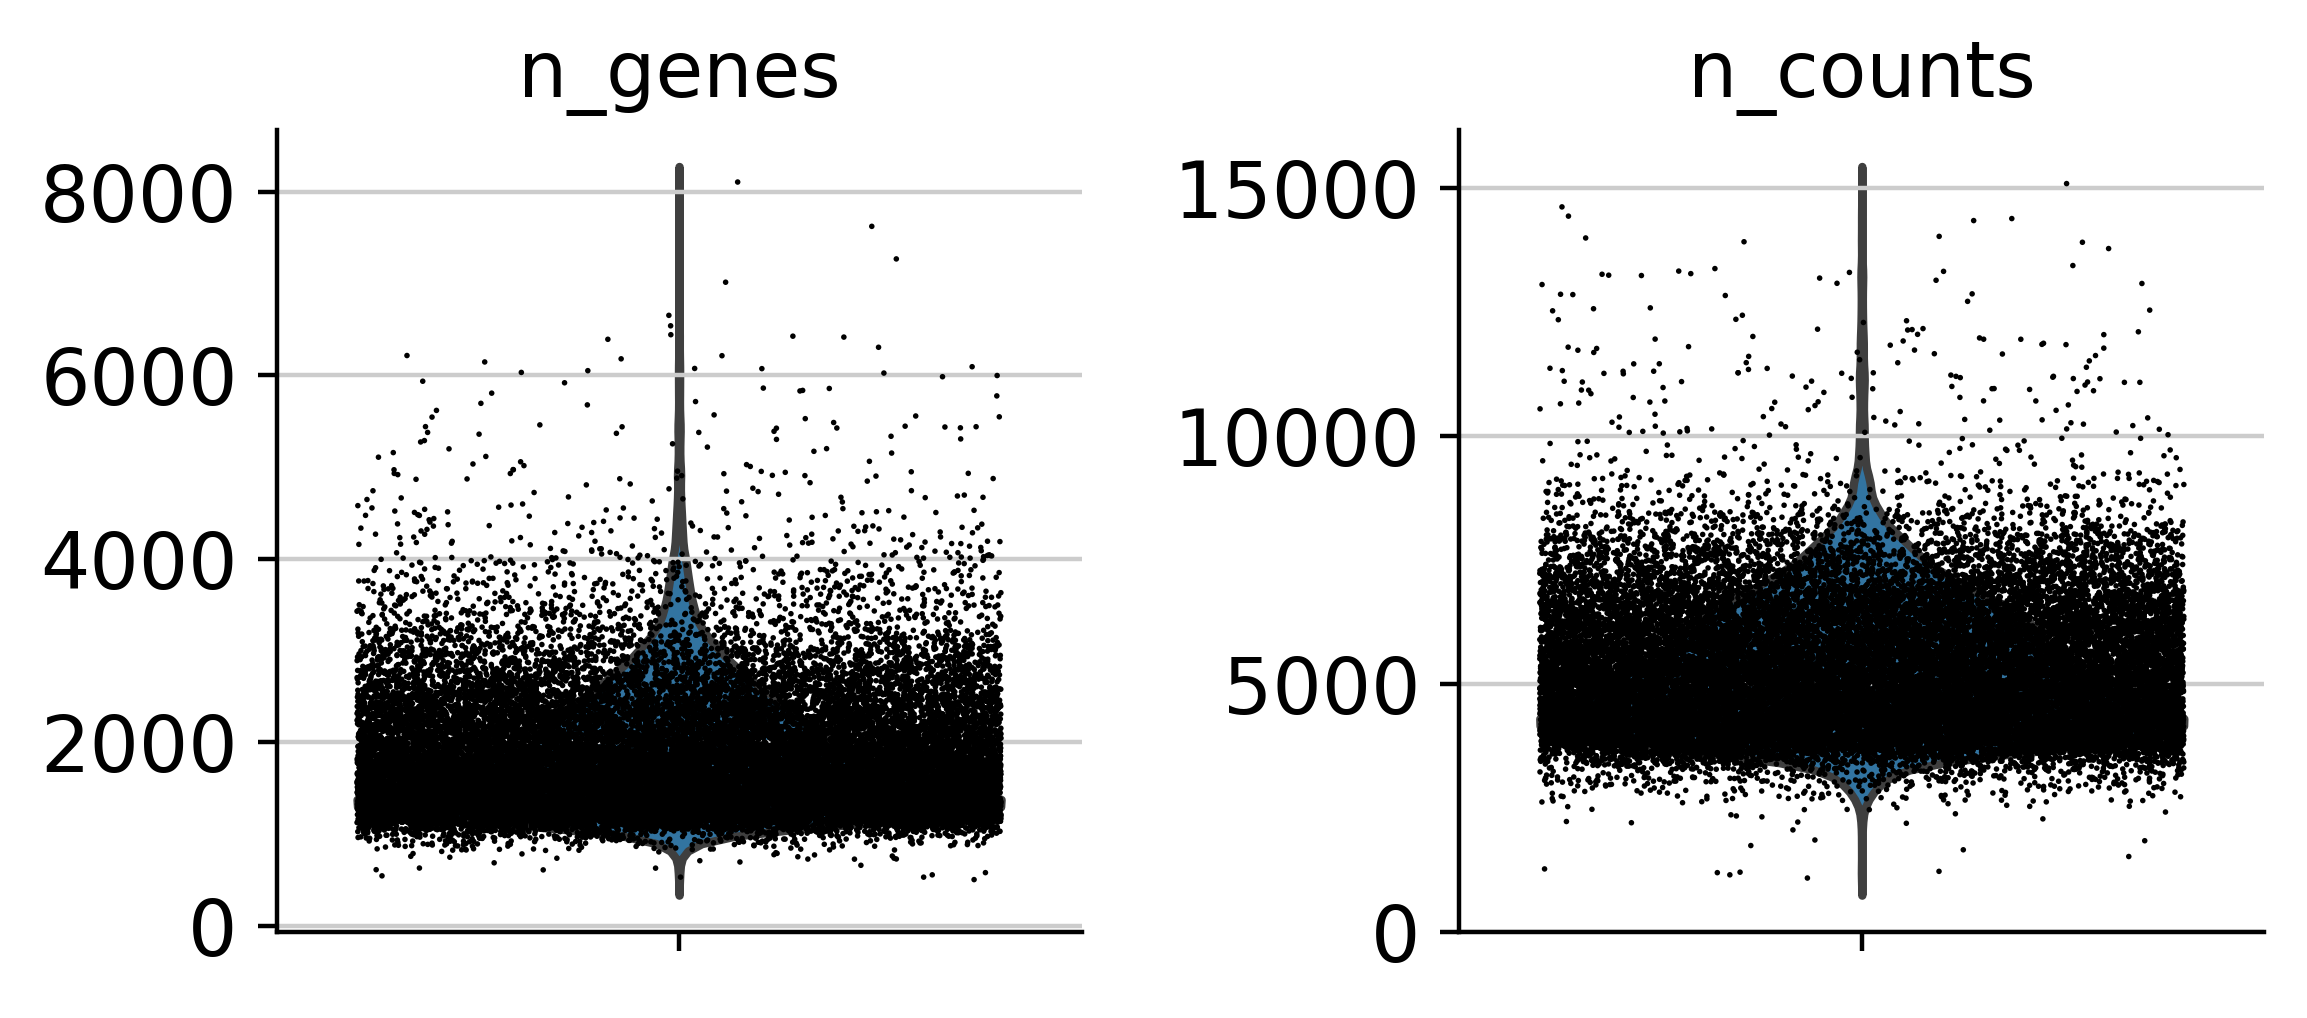

In [15]:
axs = sc.pl.violin(tiss, ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

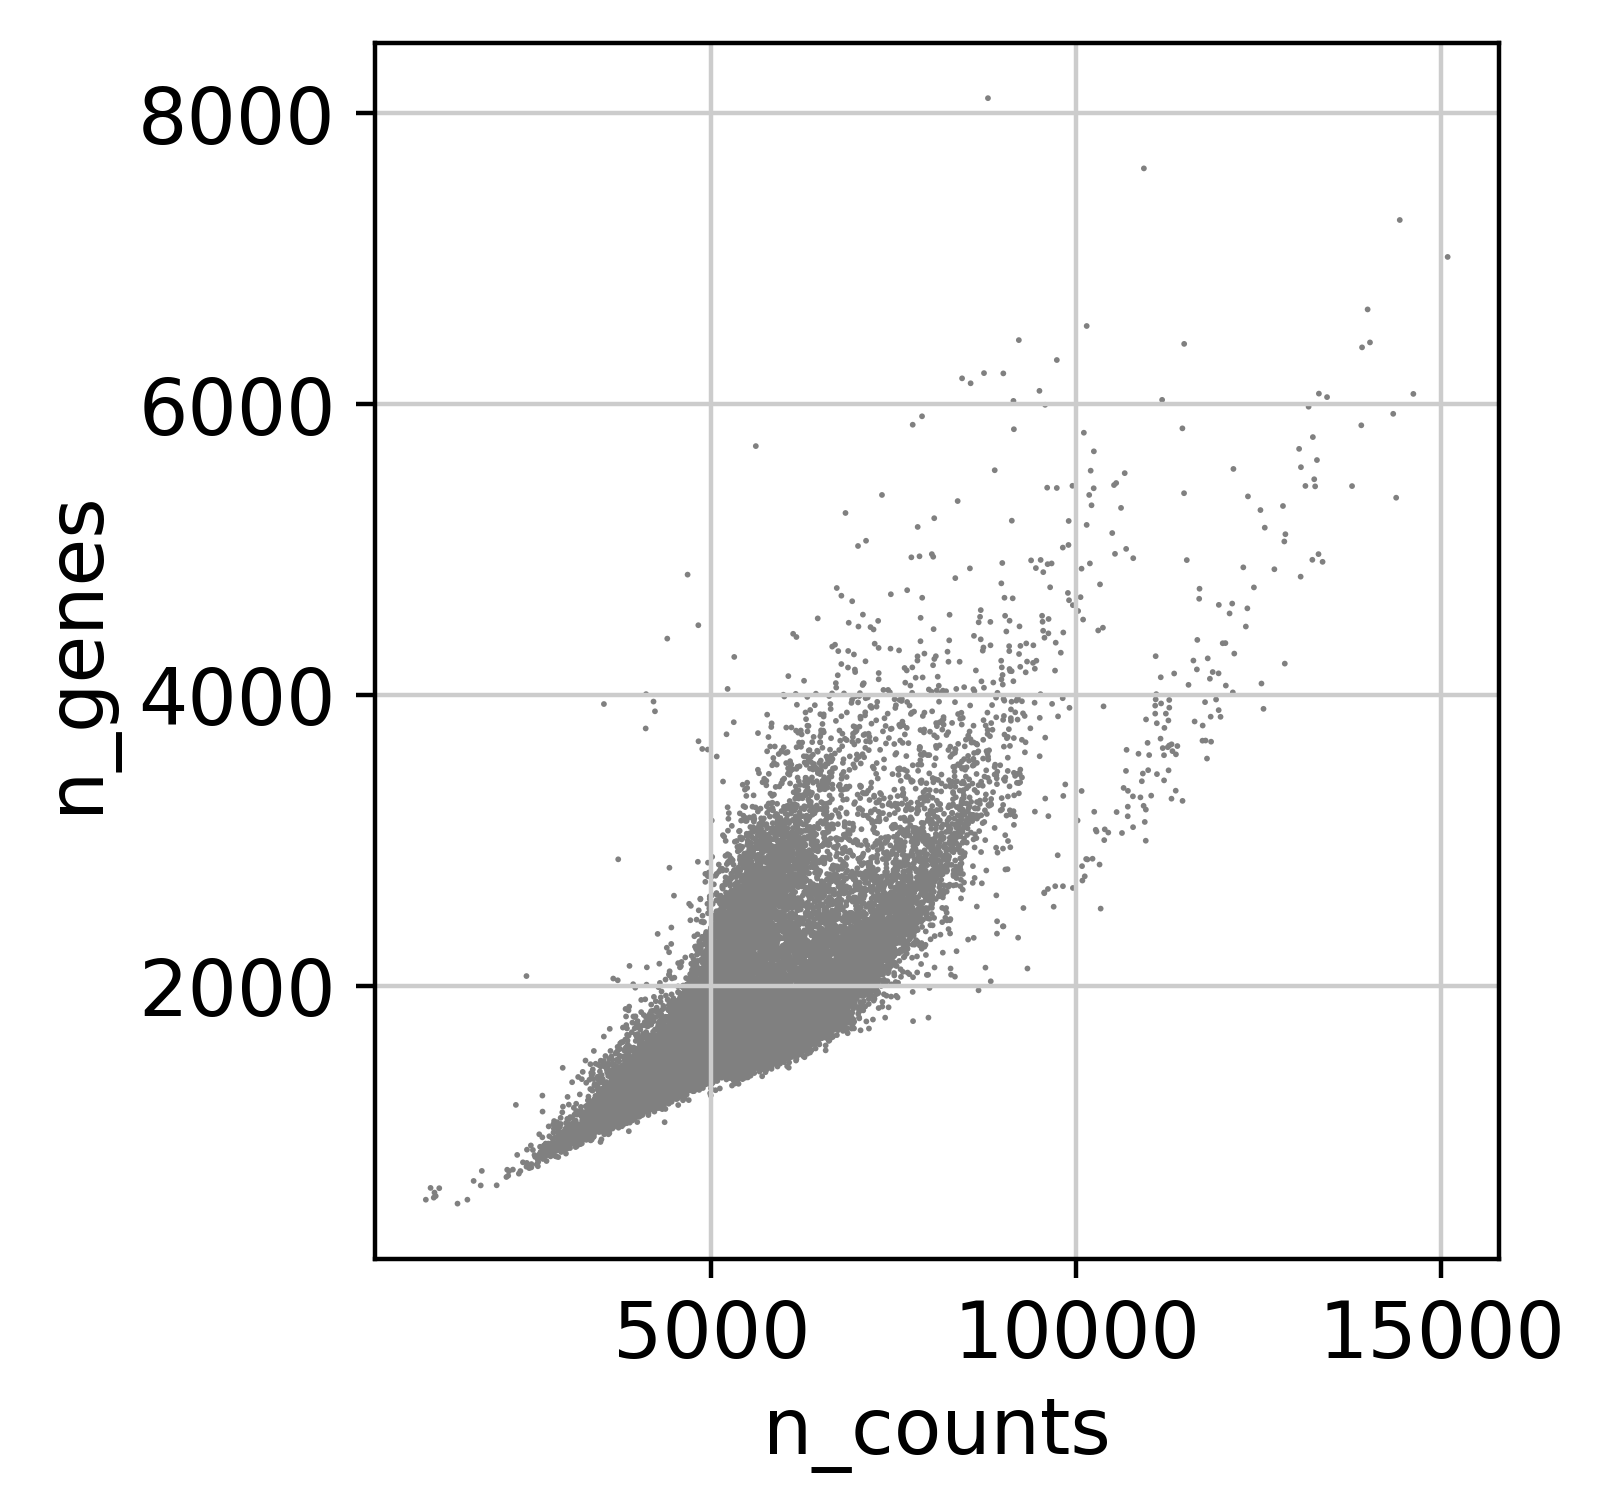

In [16]:
ax = sc.pl.scatter(tiss, x='n_counts', y='n_genes')

In [17]:
sc.pp.normalize_per_cell(tiss, counts_per_cell_after=1e4) #simple lib size normalization?
tiss.raw = tiss

In [18]:
tiss = sc.pp.filter_genes_dispersion(tiss, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
tiss

AnnData object with n_obs × n_vars = 27757 × 16831 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'sex_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [19]:
sc.pp.log1p(tiss)

In [20]:
sc.pp.scale(tiss, max_value=10, zero_center=False)

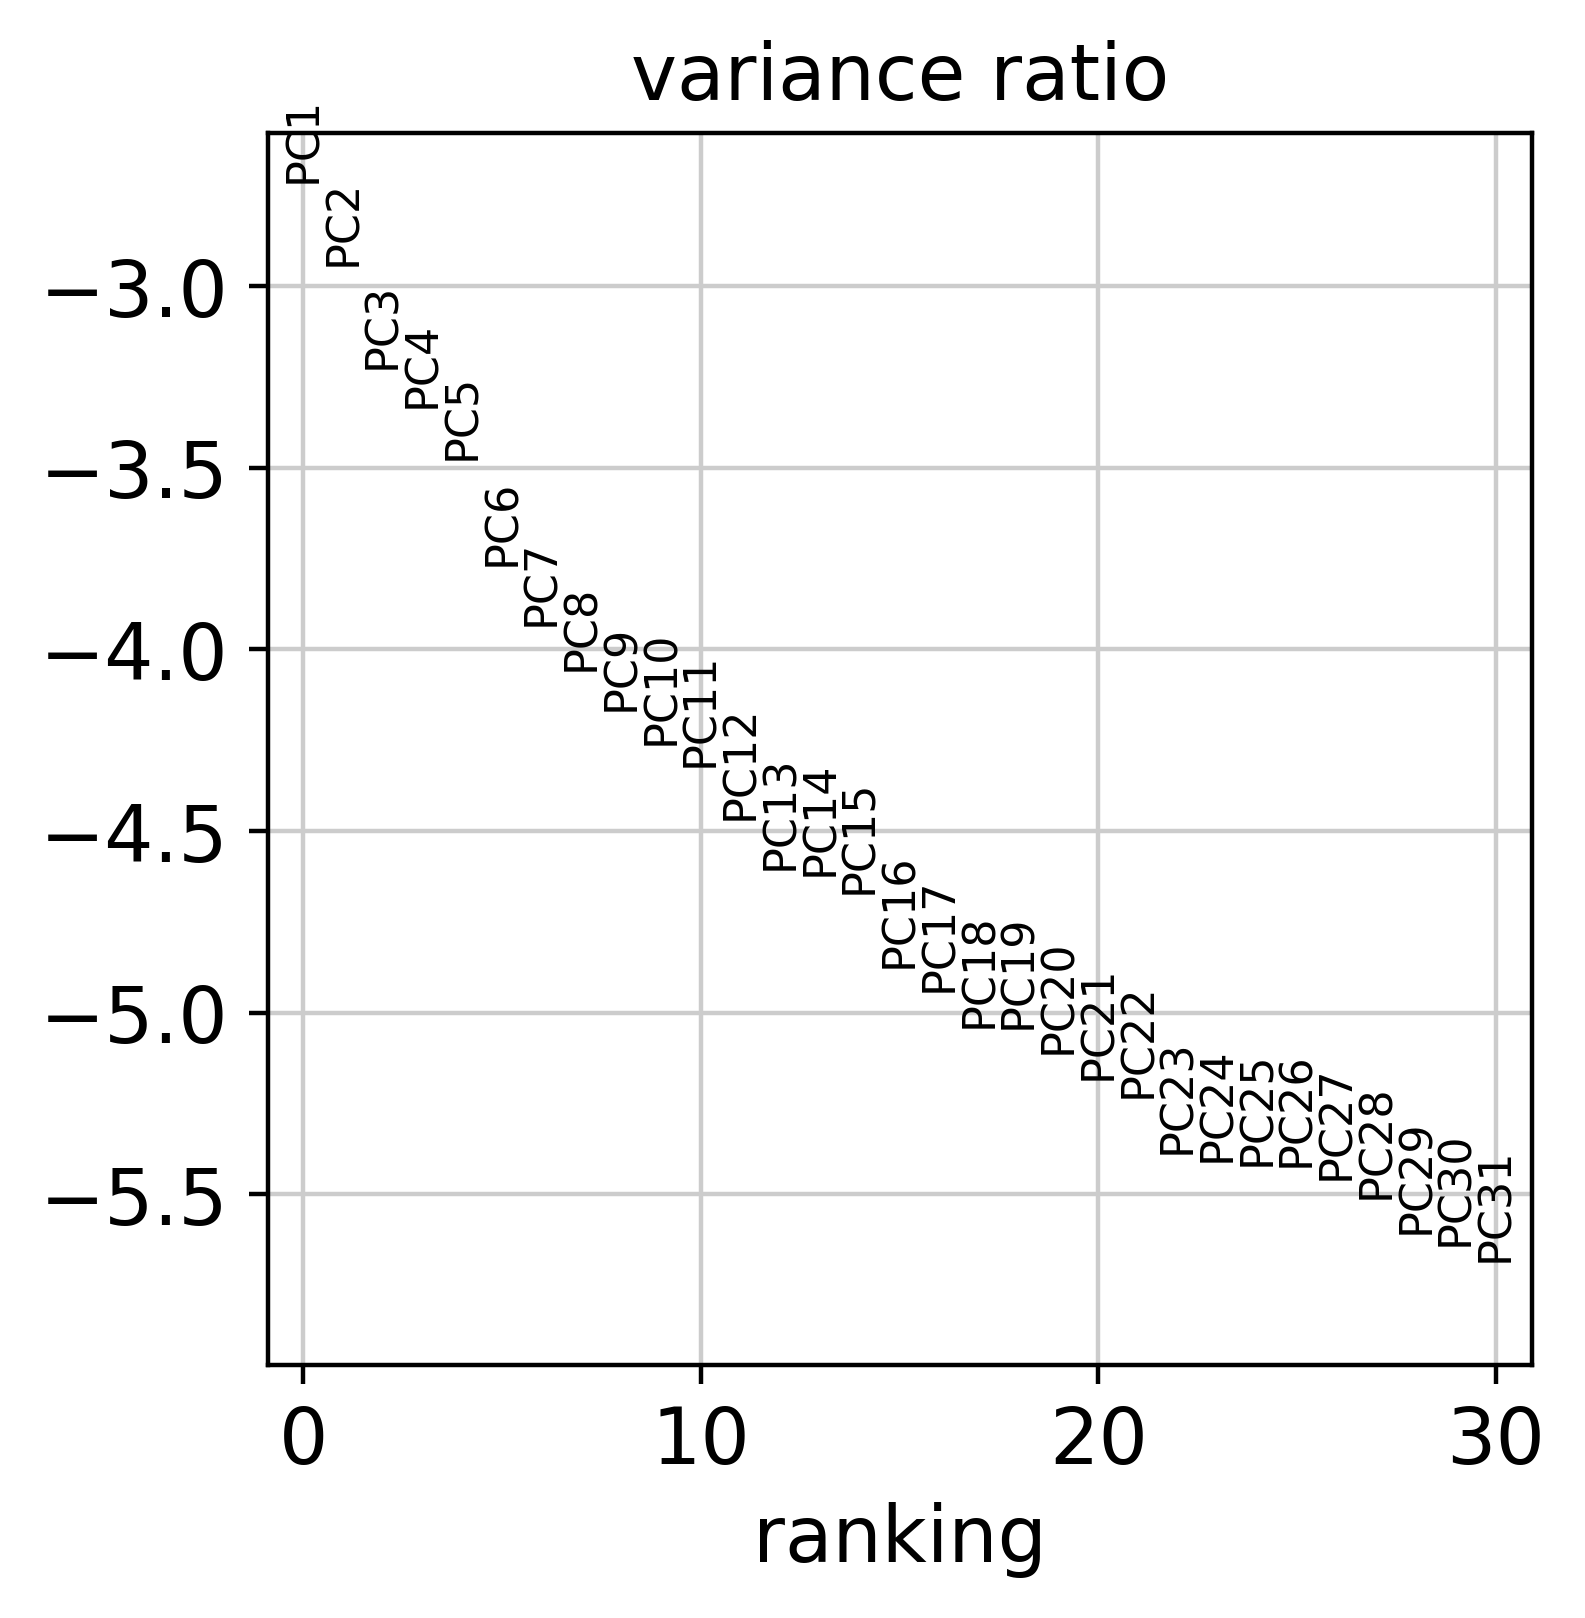

In [21]:
sc.tl.pca(tiss)
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
# tiss = bbknn.bbknn(tiss, neighbors_within_batch=12, save_knn=True, copy=True)

In [23]:
sc.pp.neighbors(tiss, n_neighbors=12, n_pcs=30)#, method='gauss')

In [24]:
sc.tl.louvain(tiss, resolution = 1)

In [25]:
sc.tl.umap(tiss, n_components=30)

In [26]:
len(set(tiss.obs['louvain'])),len(set(tiss.obs['cell_ontology_class']))

(30, 15)

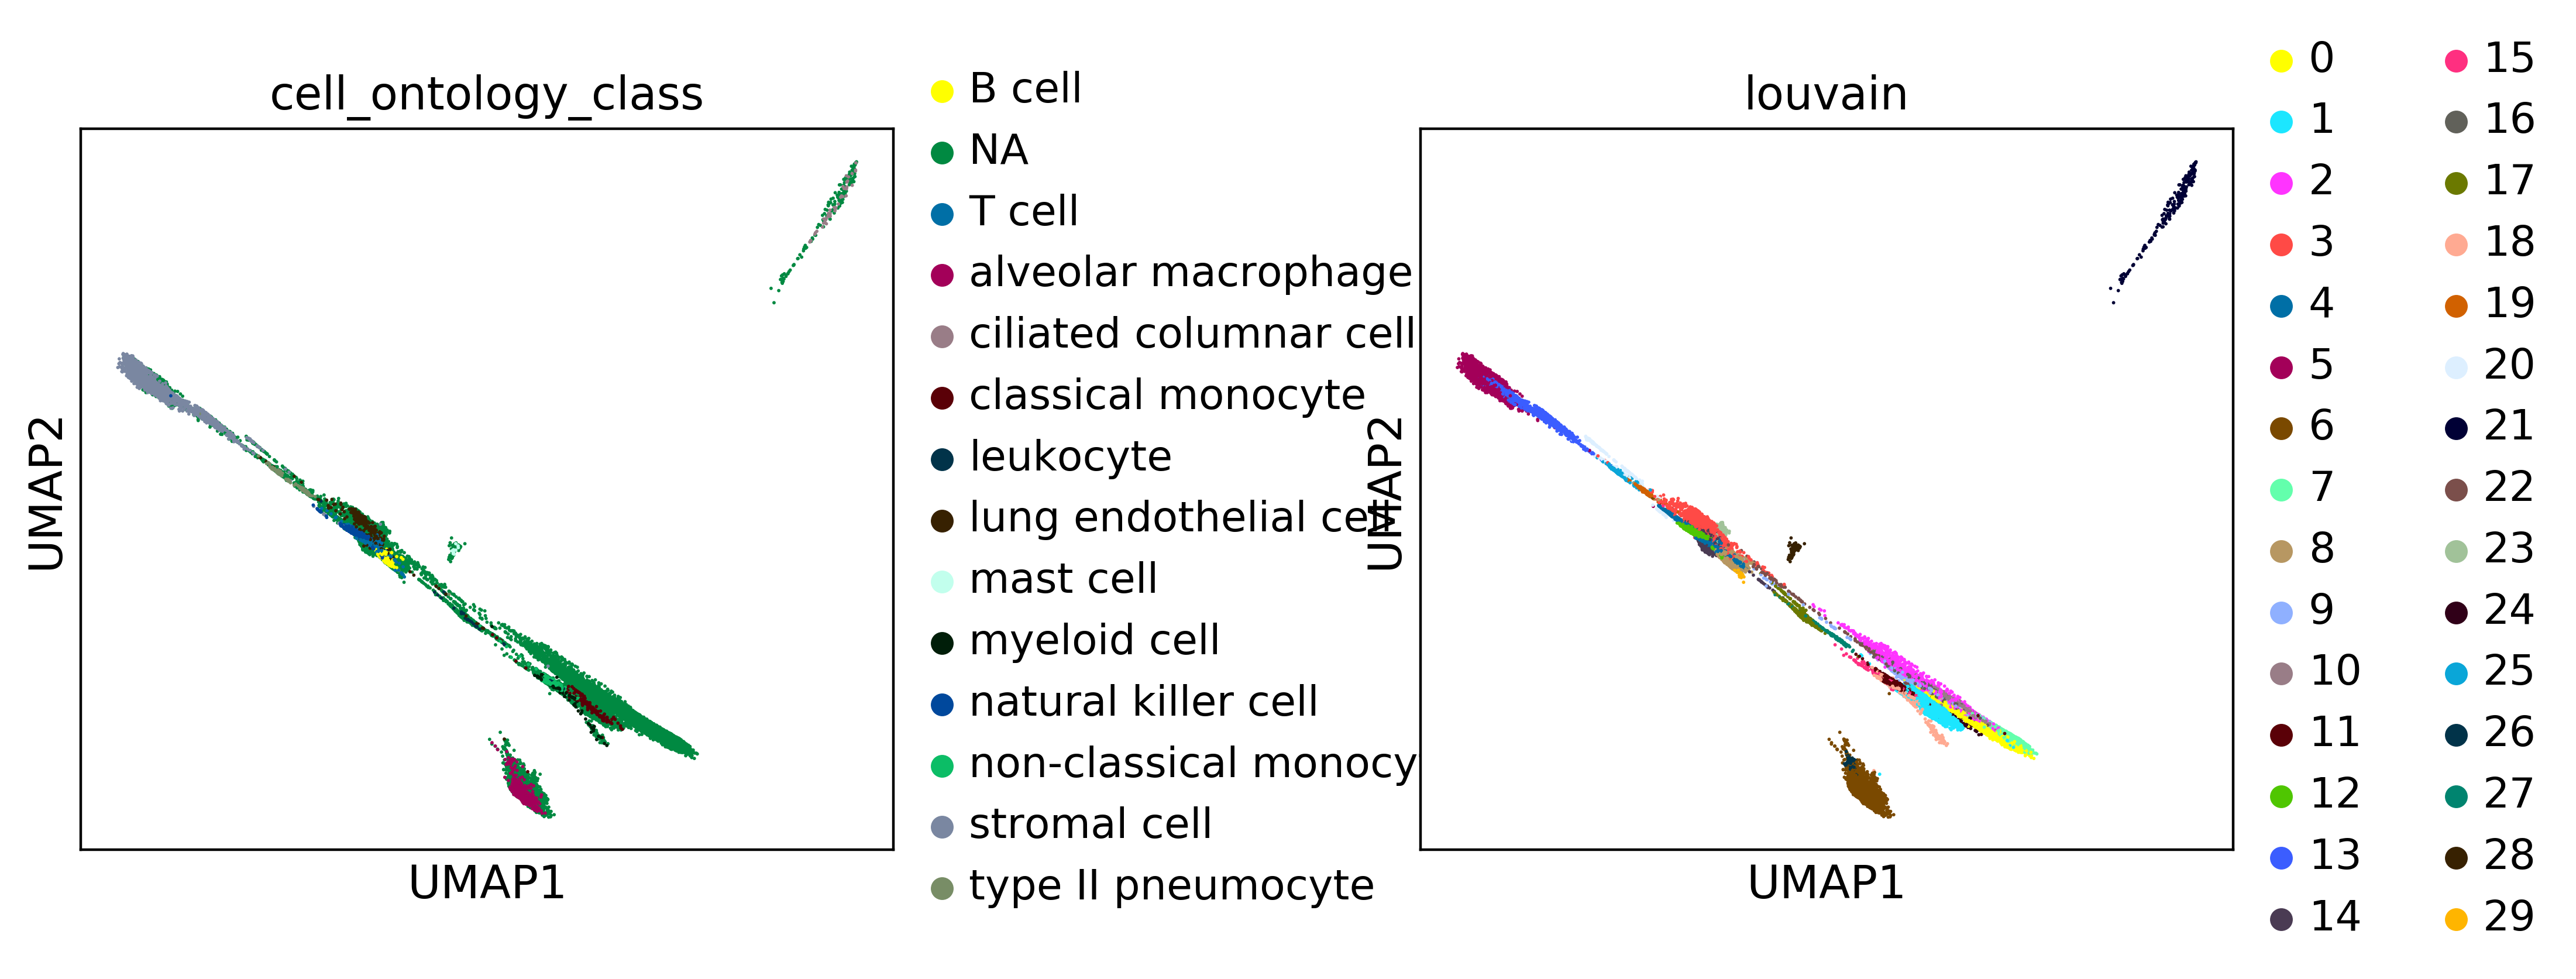

In [27]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['cell_ontology_class','louvain'],ncols=2,wspace=.5)#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['age','mouse.id'],ncols=2,wspace=.5)#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['tissue_free_annotation'])#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_louvain.pdf')

In [28]:
sc.tl.tsne(tiss, perplexity=50,n_pcs=30)

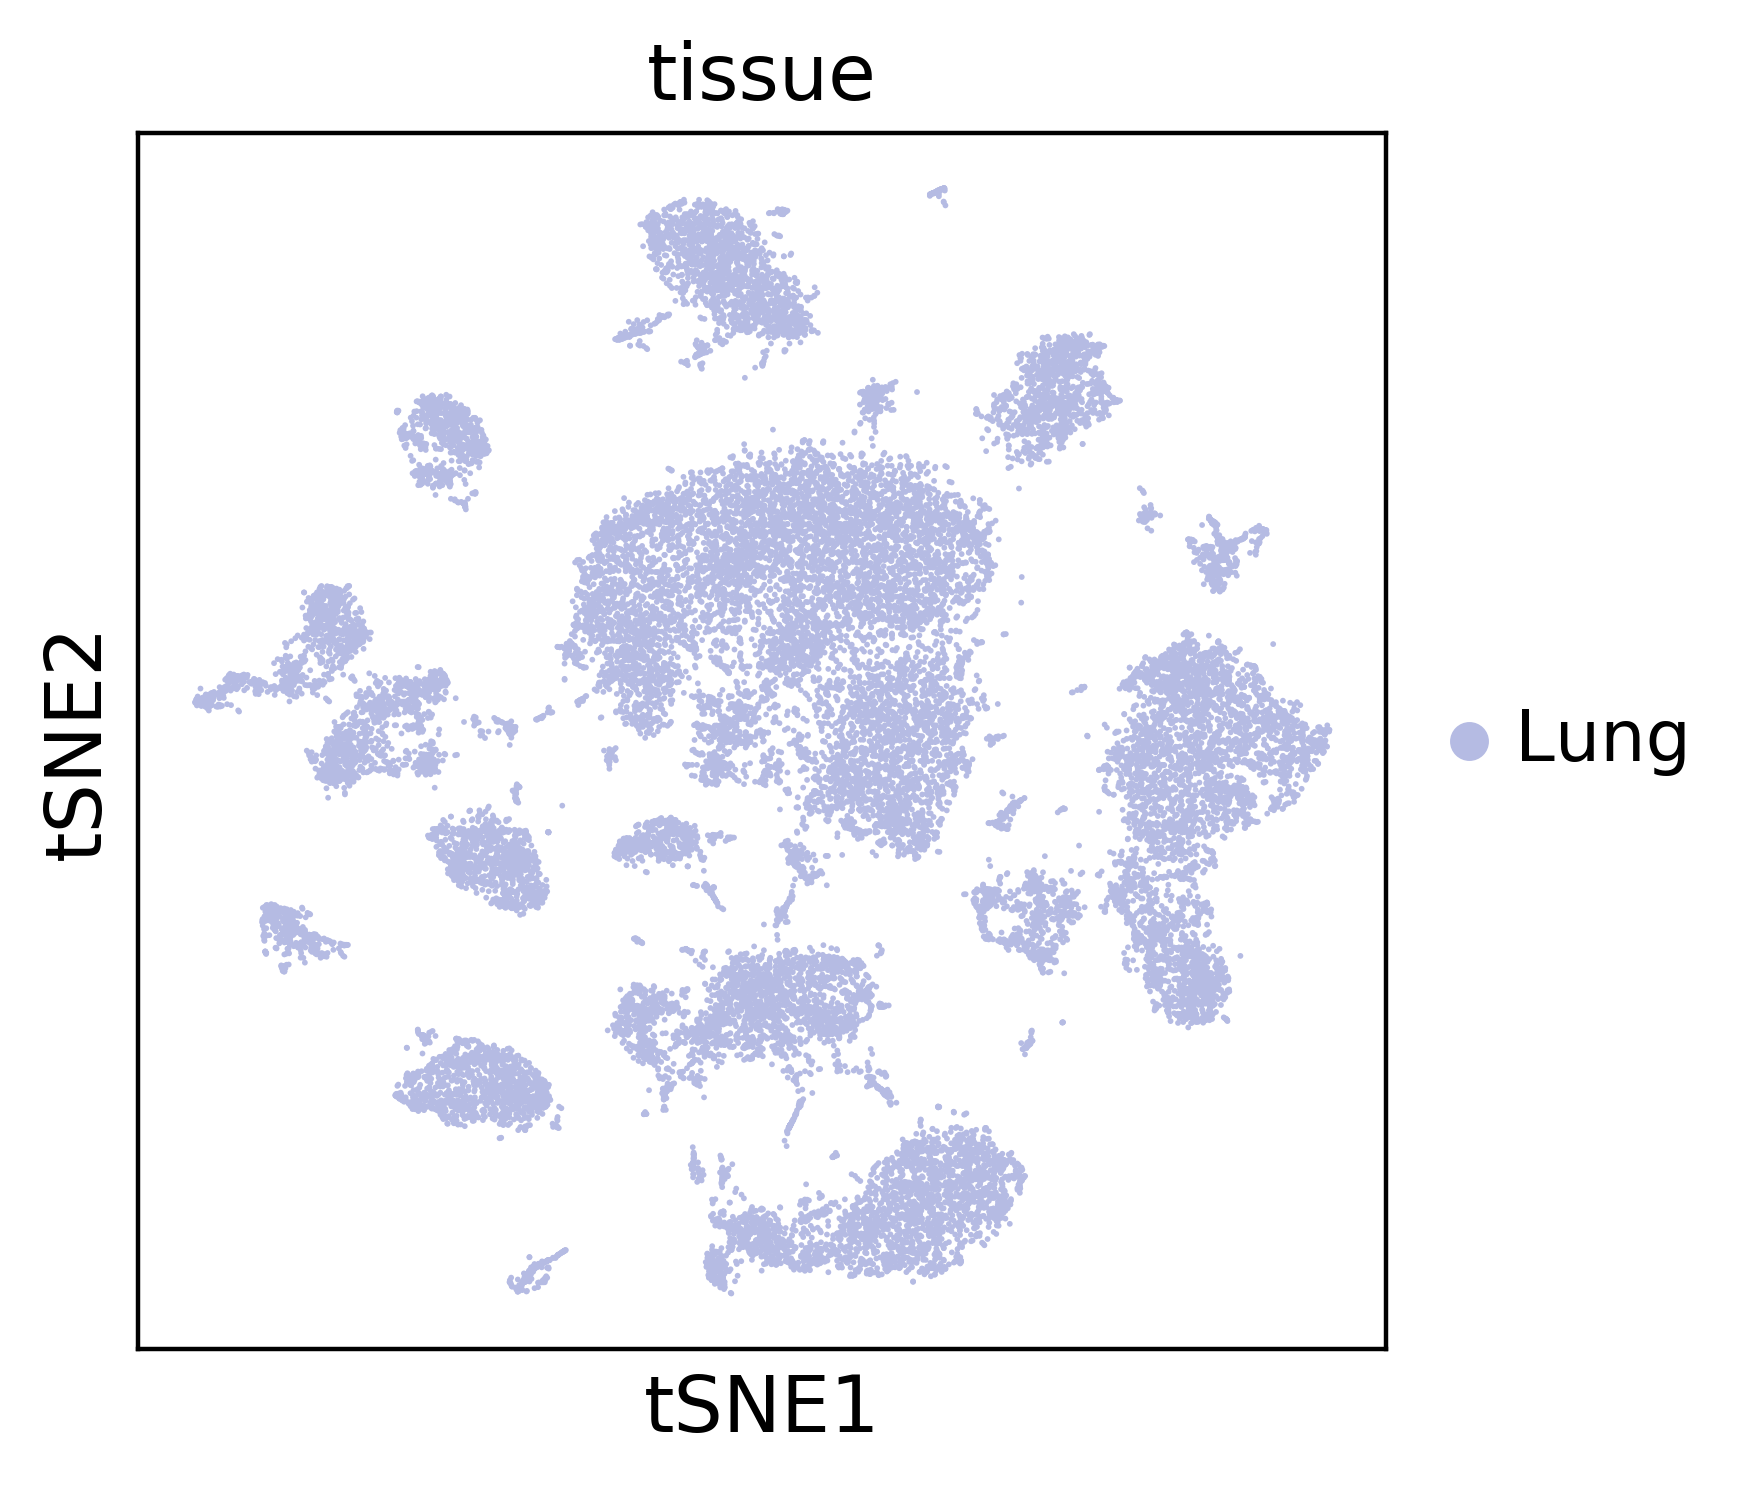

In [29]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['tissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_tissue.pdf')

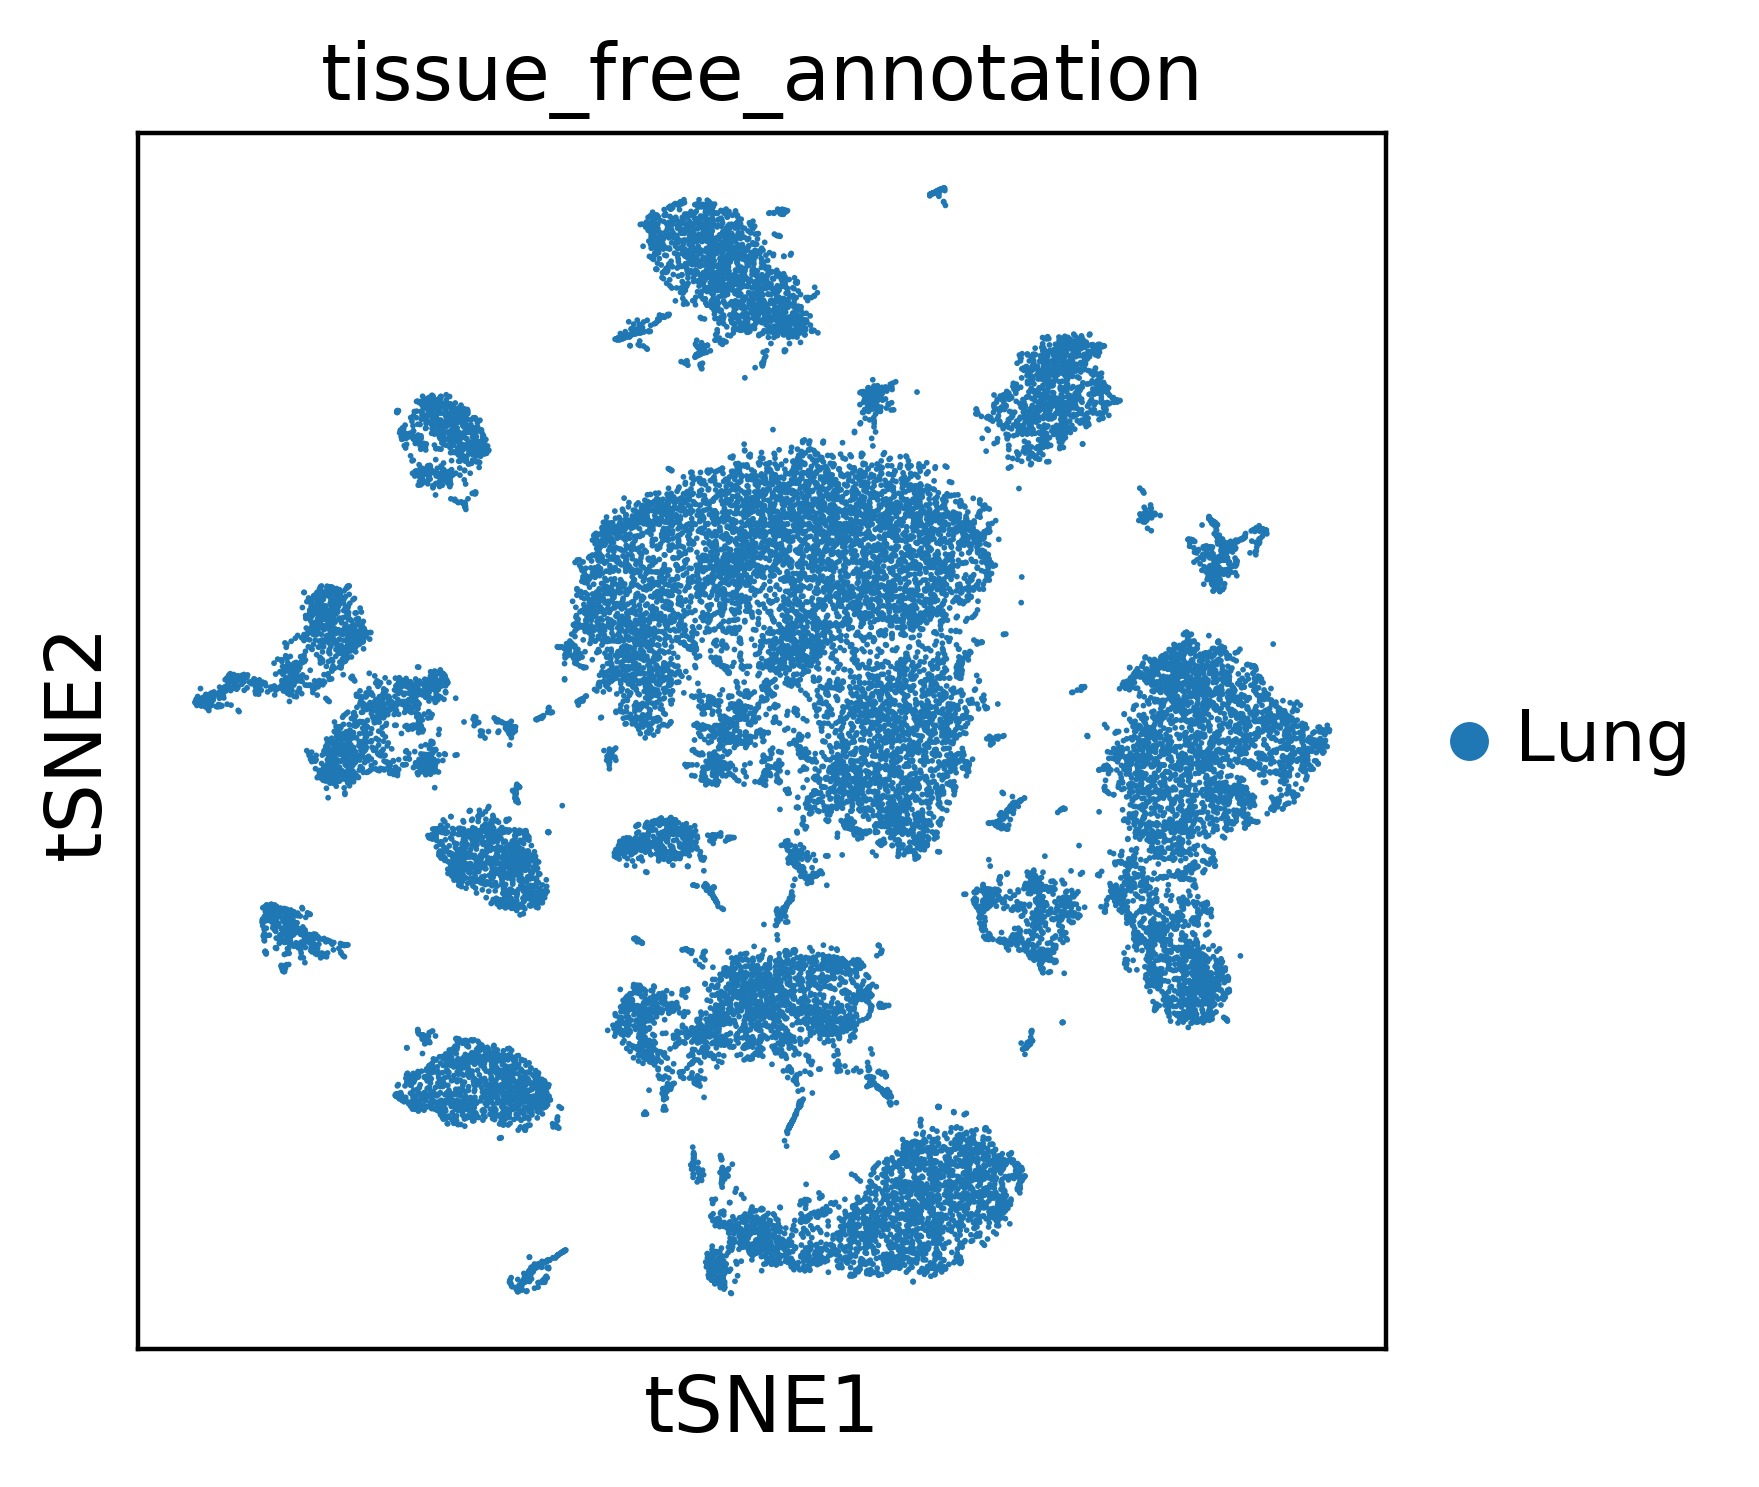

In [30]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['tissue_free_annotation'])#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_tissue.pdf')

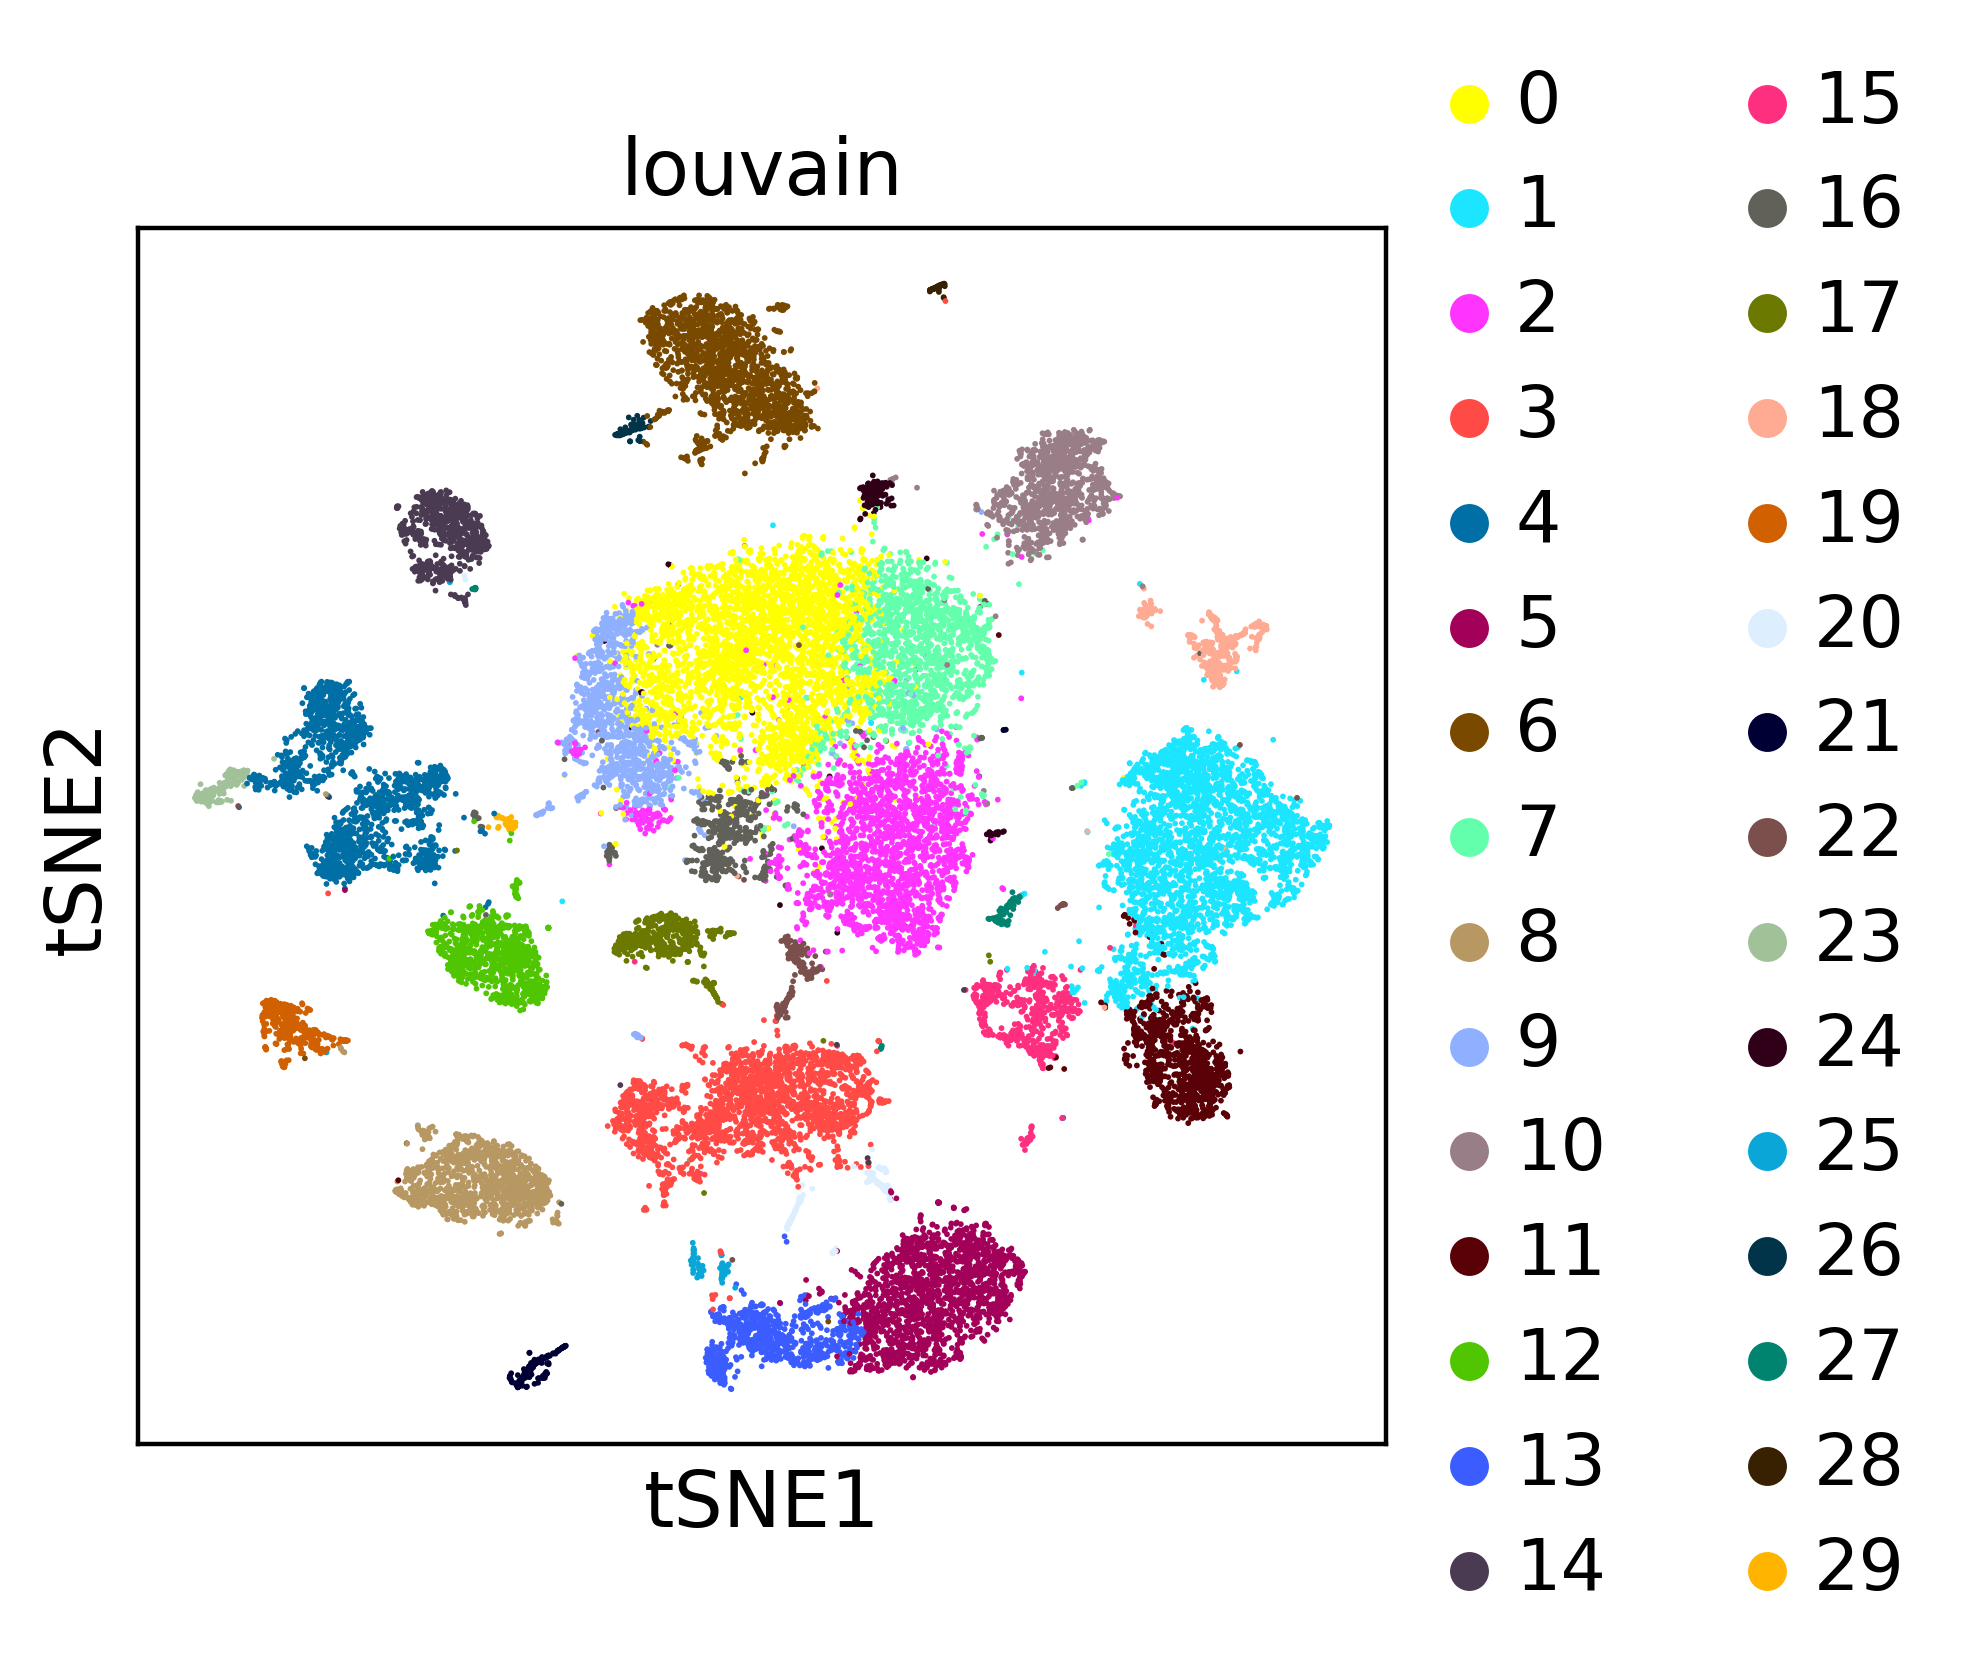

In [31]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_tissue.pdf')

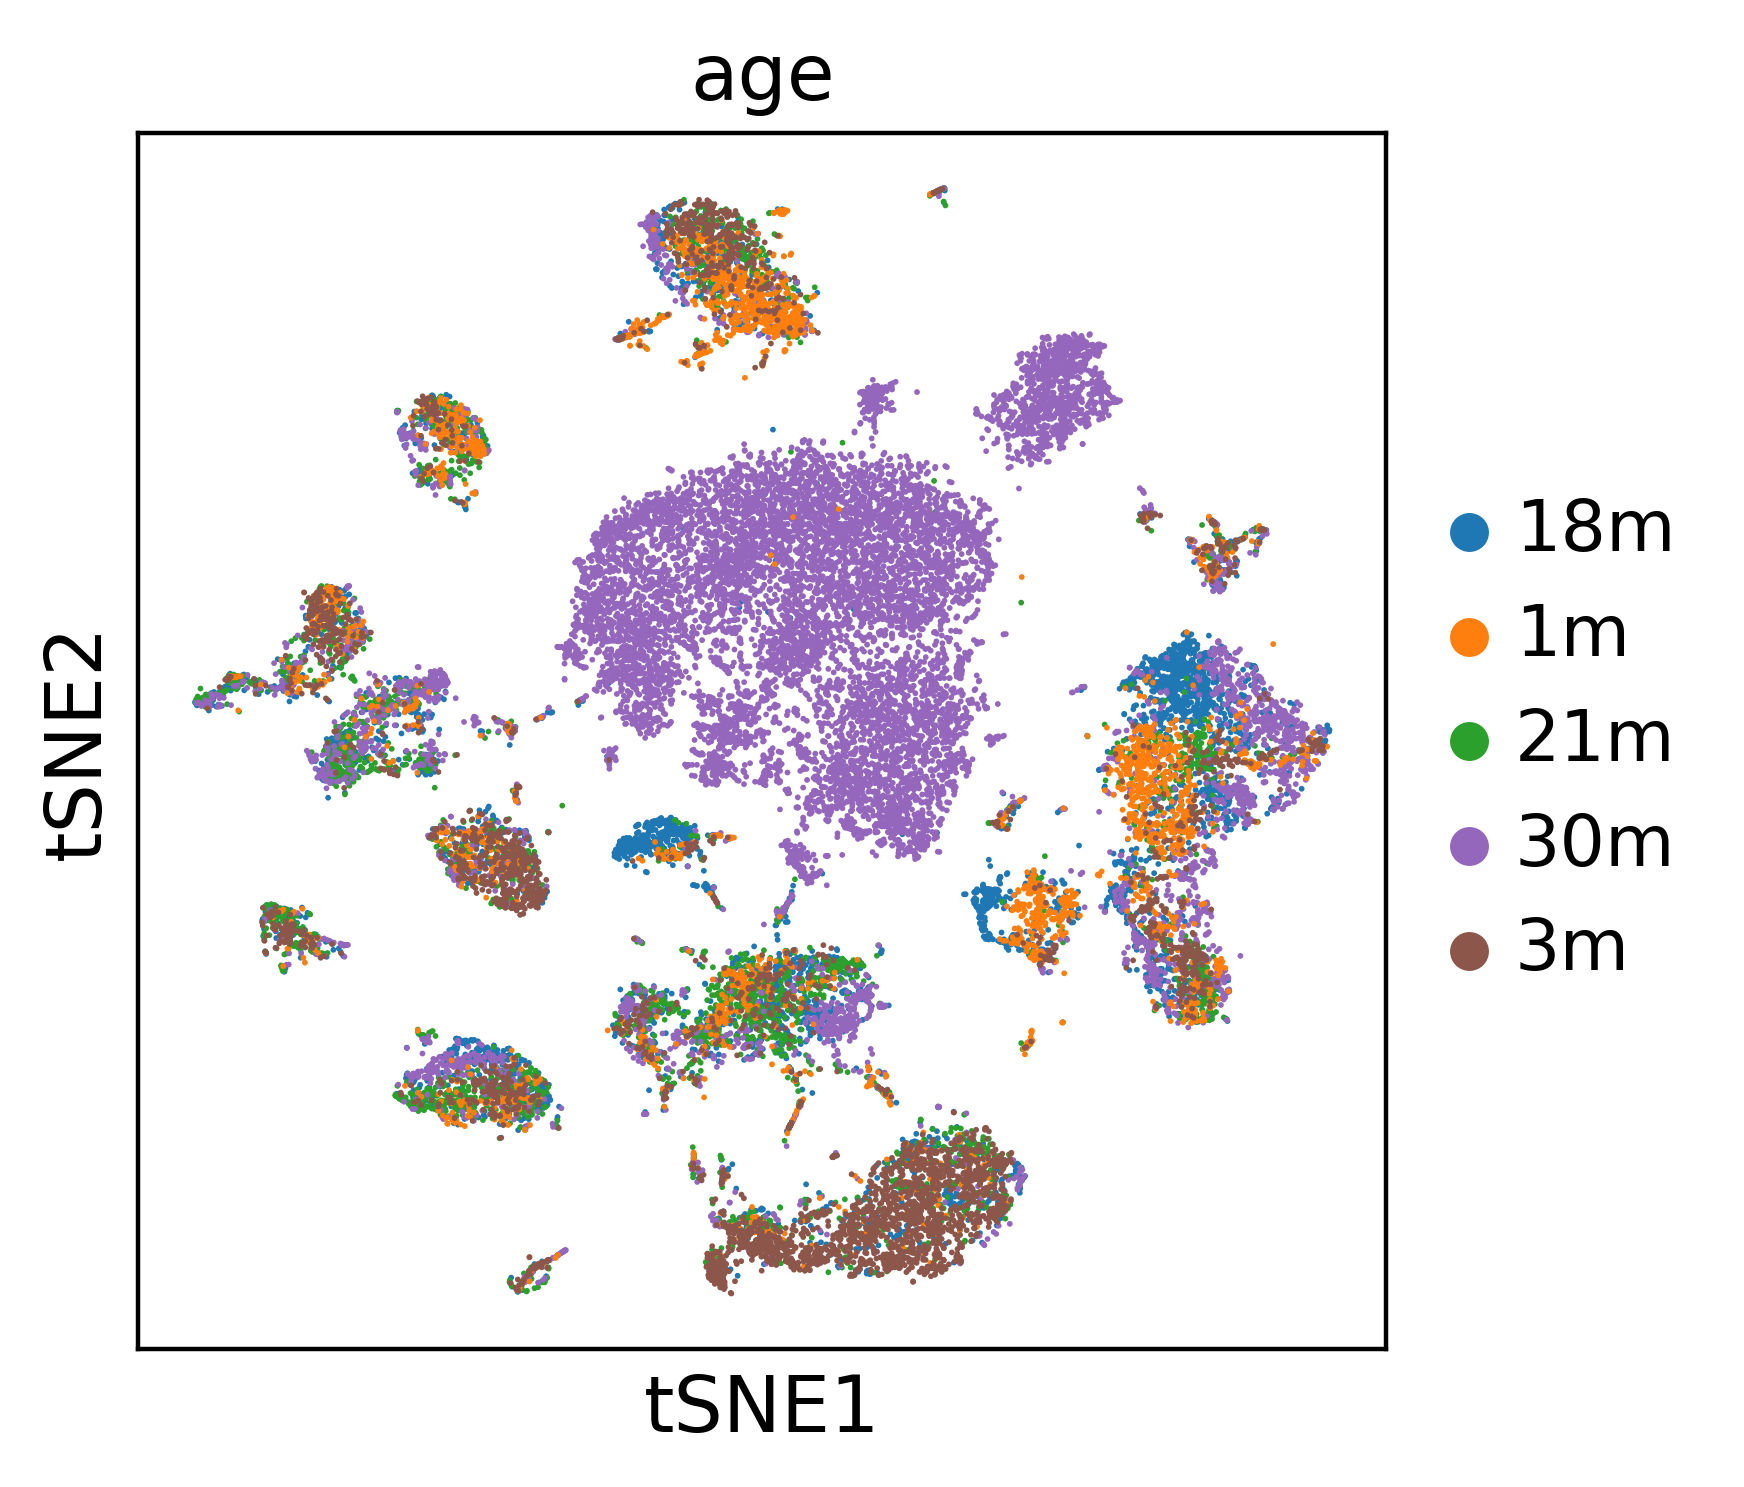

In [32]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_tissue.pdf')

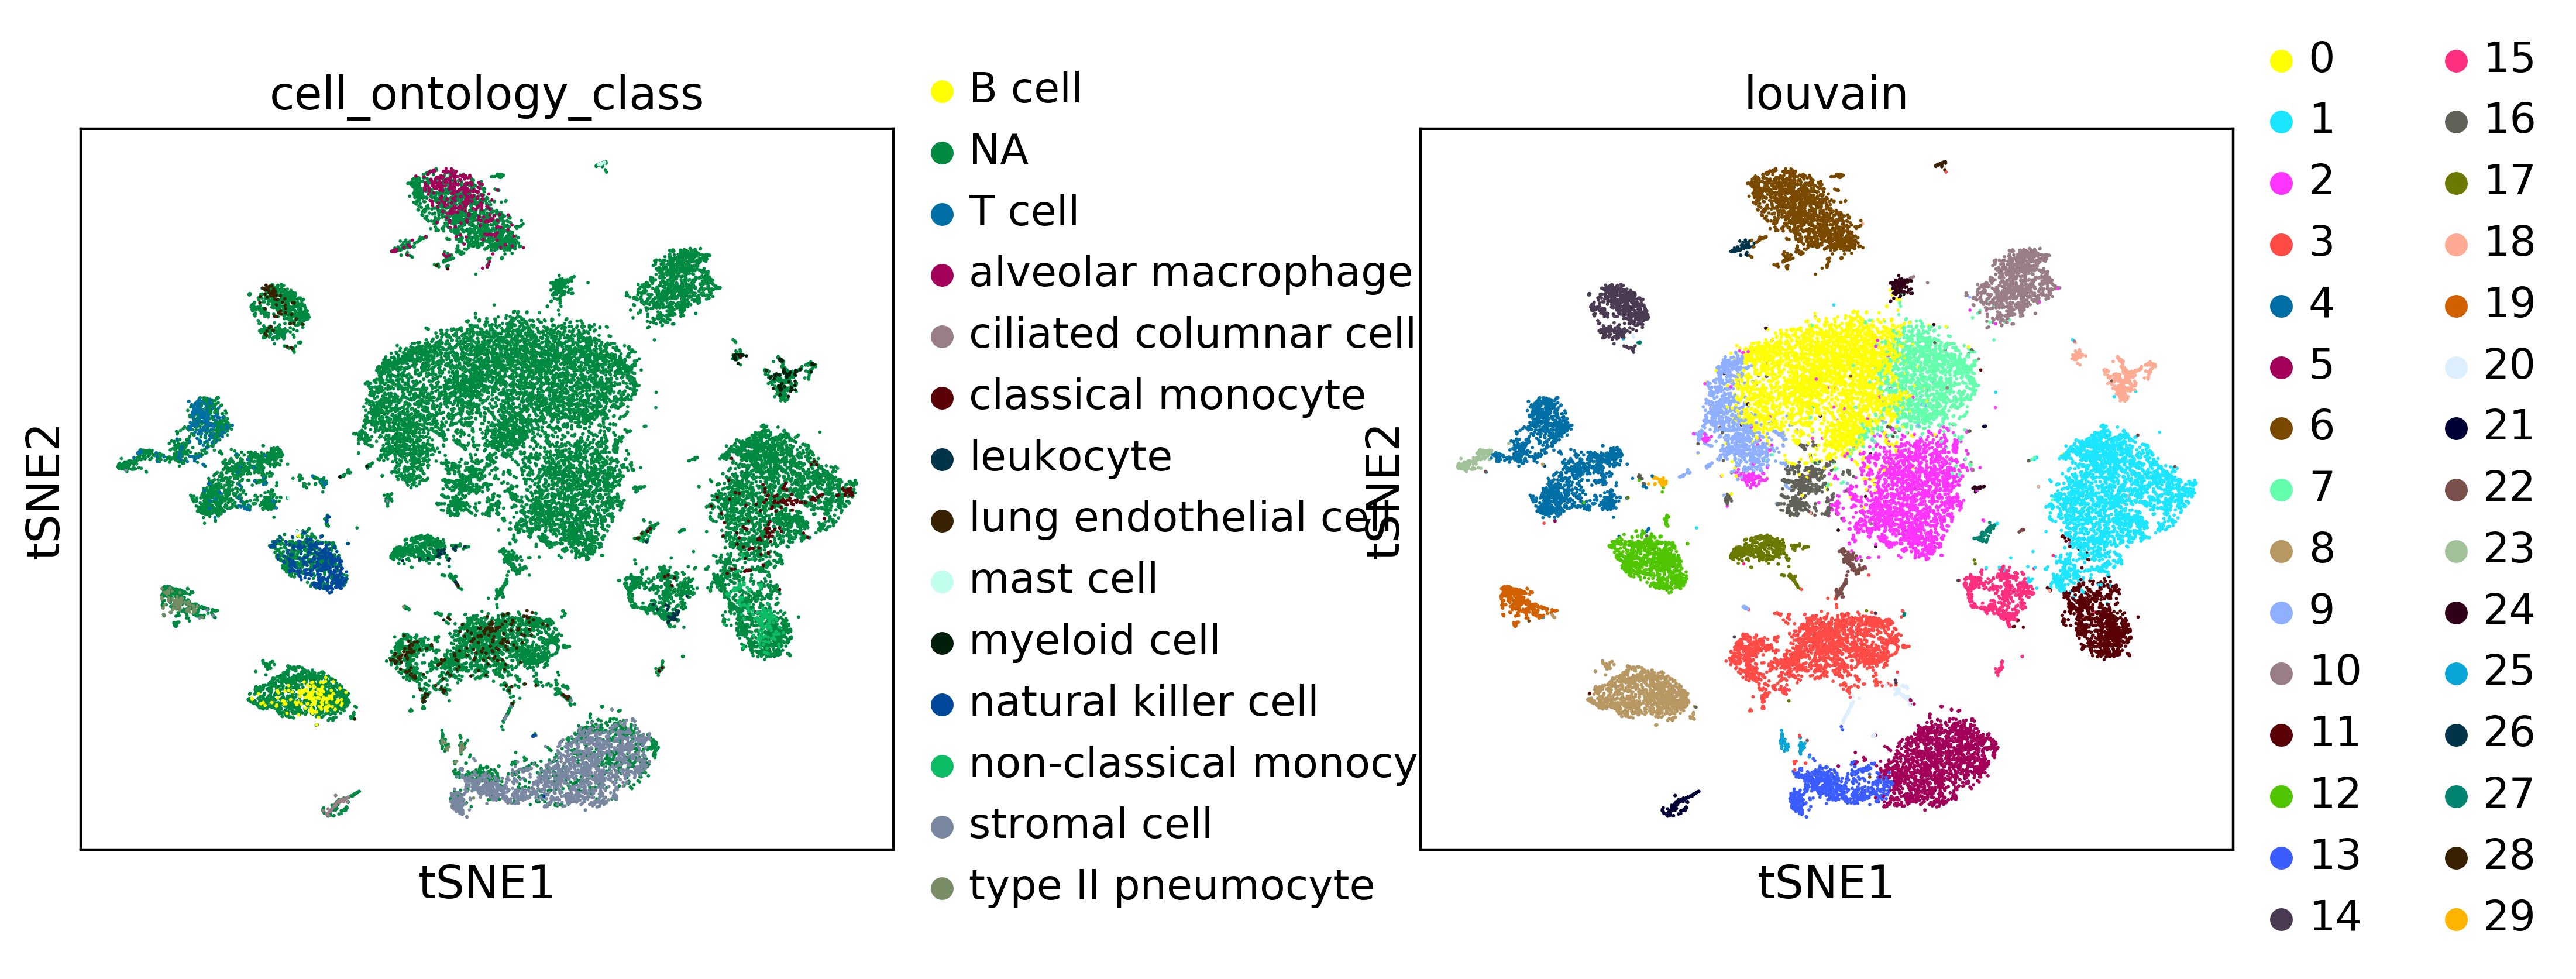

In [33]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'],ncols=2,wspace=.5)#, save = '_'+ str(tissofinterest) +'_all-ages_droplet_tissue.pdf')

## Create the mapping dictionary from previously existing `cell_ontology_class` annotations to new `Louvain` clusters

In [ ]:
ageofinterest = "3m"
tissage = tiss[tiss.obs['age'] == ageofinterest,:]
tissage

In [ ]:
sc.pl.umap(tissage, color=['cell_ontology_class','louvain'],ncols=2,wspace=.5)

In [ ]:
sc.pl.umap(tissage, color=['cell_ontology_class'])

In [ ]:
tiss_cell_ontology_class = {}
for i in set(tissage.obs['louvain']):
    df = tissage.obs[tissage.obs['louvain']==i]['cell_ontology_class']
    df.reset_index()
    df = df.reset_index()
    dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    a = dfaux[dfaux['index']>0.90][['cell_ontology_class']]
    if a.empty:
        tiss_cell_ontology_class[i] = 'tbc'
    else:
        tiss_cell_ontology_class[i] = a.values[0][0]

tiss_cell_ontology_class

In [ ]:
display(set(tiss_cell_ontology_class.values()))
display(set(tissage.obs['cell_ontology_class']))

set(tiss.obs['cell_ontology_class'])

### And repeat for  `free_annotation`

In [ ]:
tiss_free_annotation = {}
for i in set(tissage.obs['louvain']):
    df = tissage.obs[tissage.obs['louvain']==i]['free_annotation']
    df.reset_index()
    df = df.reset_index()
    dfaux = df.groupby('free_annotation').count()/df.groupby('free_annotation').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    a = dfaux[dfaux['index']>0.90][['free_annotation']]
    if a.empty:
        tiss_free_annotation[i] = 'nan'
    else:
        tiss_free_annotation[i] = a.values[0][0]

tiss_free_annotation

In [ ]:
display(set(tiss_free_annotation.values()))
set(tiss.obs['free_annotation'])

### check if there are new clusters comparing to 3mo data

In [ ]:
new_populations = {}
if set(tissage.obs['louvain']) != set(tiss.obs['louvain']):
    new_clusters = list(set(tiss.obs['louvain']) - set(tissage.obs['louvain']))
    for i in range(0,len(new_clusters)):
        new_populations[new_clusters[i]] = 'new-cluster'
    print(new_populations)
    tiss_cell_ontology_class = {**tiss_cell_ontology_class, **new_populations}
    tiss_free_annotation = {**tiss_free_annotation, **new_populations}
    

In [ ]:
new_populations_ages = {}
j = 0
print(tissofinterest)
for i in new_populations.keys():
    j=j+1
    print(i, set(tiss.obs['age'][tiss.obs['louvain']==i]))
    new_populations_ages[j,1] = i
    new_populations_ages[j,2] = set(tiss.obs['age'][tiss.obs['louvain']==i])

new_populations_ages    

# import csv
# from itertools import zip_longest

# # d = [[2,3,4,8],[5,6]]

# with open(tissofinterest + '_new_populations_ages.csv','w+') as f:
#     writer = csv.writer(f)
#     for values in zip_longest(*new_populations_ages):
#         writer.writerow(values)

## now map the whole dataset with the dictionaries created using the existing annotations

In [ ]:
tiss.obs['auto_cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)
set(tiss.obs['cell_ontology_class'])

In [ ]:
tiss.obs['auto_free_annotation'] = tiss.obs['louvain'].map(tiss_free_annotation)
set(tiss.obs['free_annotation'])

In [ ]:
sc.pl.tsne(tiss, color=['louvain'])

In [ ]:
sc.pl.tsne(tiss, color=['cell_ontology_class'],
           save='_'+ str(tissofinterest) +'_all-ages_droplet_cell_ontology_class.pdf')

In [ ]:
sc.pl.tsne(tiss, color=['free_annotation','age'])

In [ ]:
sc.pl.umap(tiss, color=['cell_ontology_class','age','auto_cell_ontology_class','louvain'],ncols=2,wspace=.6)#,
#            save='_' + str(tissofinterest) + '_all-ages_droplet_cell_ontology_class_age.pdf')

In [ ]:
sc.pl.umap(tiss, color=['age','louvain'],
           save='_' + str(tissofinterest) + '_all-ages_droplet_louvain_age.pdf')

In [ ]:
sc.pl.umap(tiss, color=['louvain'])

In [ ]:
sc.pl.tsne(tiss,
           color=['cell_ontology_class','louvain',
                  'auto_cell_ontology_class','age',
                  'mouse.id','sex'],
           ncols=2,wspace=.6)

In [ ]:
sc.pl.tsne(tiss,
           color=['cell_ontology_class','louvain',
                  'auto_cell_ontology_class','age',
                  'mouse.id','sex'],
           ncols=2,wspace=.6,save = '_'+tissofinterest + '_multipanel_processed_data')

In [ ]:
sc.pl.umap(tiss,
           color=['cell_ontology_class','louvain',
                  'auto_cell_ontology_class','age',
                  'mouse.id','sex'],
           ncols=2,wspace=.6,save = '_'+tissofinterest + '_multipanel_processed_data')

In [ ]:
tiss.obs['cluster_names'] = tiss.obs['louvain'].astype(str)+'_'+tiss.obs['auto_cell_ontology_class'].astype(str)

In [ ]:
sc.tl.rank_genes_groups(tiss, 'cluster_names')#,penalty='l1')

In [ ]:
tiss_cluster_genes = pd.DataFrame(tiss.uns['rank_genes_groups']['names'])
tiss_cluster_genes.head(25)

In [ ]:
set(tiss[tiss.obs['cluster_names']=='24_hematopoietic precursor cell'].obs['cell_ontology_class'])

In [ ]:
marker_genes = [name for name in tiss_cluster_genes['24_hematopoietic precursor cell'] if name.startswith('P')]
marker_genes

In [ ]:
sc.pl.tsne(tiss,color=['louvain'],legend_loc='on data')

In [ ]:
sc.pl.tsne(tiss[tiss.obs['louvain']=='24'],color=['Cd74','Cd79a','Dntt','Vpreb1','Pax5','Rag1','Rag2','Cd19','Ms4a1','Mki67','Stmn1','Chchd10','Ahnak','Mpeg1','Emr1','Cd68'])


In [ ]:
sc.pl.tsne(tiss[tiss.obs['louvain']=='24'],color=['Kit','Gpr56','Cd34','Slamf1','Stmn1','Mki67','Cd48','Flt3','Pdzk1ip1','Tgm2','Klf1','Treml1'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='25'],color=['Kit','Gpr56','Cd34','Slamf1','Stmn1','Mki67','Cd48','Flt3','Pdzk1ip1','Tgm2','Klf1','Treml1'])

In [ ]:
sc.pl.tsne(tiss[tiss.obs['louvain']=='26'],color=['Ccl3','Fcer1a'])

In [ ]:
sc.pl.tsne(tiss,color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Ngp','Ccl3','Fcer1a','Mcpt8'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='10'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Ngp','Ccl3','Fcer1a','Mcpt8'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='11'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Ngp','Ccl3','Fcer1a','Mcpt8'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='12'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Ngp','Ccl3','Fcer1a','Mcpt8'])

In [ ]:
sc.pl.tsne(tiss,color=['Ahnak','Mpeg1','Emr1','Cd68','Mki67','Stmn1','Ly6d','Irf8','Cd74','Ltf','Lcn2','Pglyrp1'])
# sc.pl.tsne(tiss[tiss.obs['louvain']=='5'],color=['Ahnak','Mpeg1','Emr1','Cd68','Mki67','Stmn1','Ly6d','Irf8','Cd74'])
# sc.pl.tsne(tiss[tiss.obs['louvain']=='6'],color=['Ahnak','Mpeg1','Emr1','Cd68','Mki67','Stmn1','Ly6d','Irf8','Cd74'])
# sc.pl.tsne(tiss[tiss.obs['louvain']=='15'],color=['Ahnak','Mpeg1','Emr1','Cd68','Mki67','Stmn1','Ly6d','Irf8','Cd74'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='24'],color=['Ahnak','Mpeg1','Emr1','Cd68','Mki67','Stmn1','Ly6d','Irf8','Cd74'])

In [ ]:
sc.pl.tsne(tiss,color=['Kit','Gpr56','Cd34','Slamf1','Stmn1','Mki67','Cd48','Flt3'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='4'],color=['Kit','Gpr56','Cd34','Slamf1','Stmn1','Mki67','Cd48','Flt3'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='5'],color=['Kit','Gpr56','Cd34','Slamf1','Stmn1','Mki67','Cd48','Flt3'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='8'],color=['Kit','Gpr56','Cd34','Slamf1','Stmn1','Mki67','Cd48','Flt3'])

In [ ]:
# sc.pl.tsne(tiss,color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Flt3','Kit','Mpeg1','Fcer1a','Mcpt8','Ccl3','Ngp','S100a1'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='21'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Flt3','Kit','Mpeg1','Fcer1a','Mcpt8','Ccl3','Ngp','S100a1'])
# sc.pl.tsne(tiss[tiss.obs['louvain']=='2'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Flt3','Kit','Mpeg1','Fcer1a','Mcpt8','Ccl3','Ngp','S100a1'])
# sc.pl.tsne(tiss[tiss.obs['louvain']=='3'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Flt3','Kit','Mpeg1','Fcer1a','Mcpt8','Ccl3','Ngp','S100a1'])
# sc.pl.tsne(tiss[tiss.obs['louvain']=='4'],color=['Ltf','Pglyrp1','Lcn2','Camp','Mki67','Stmn1','Flt3','Kit','Mpeg1','Fcer1a','Mcpt8','Ccl3','Ngp','S100a1'])

In [ ]:
sc.pl.tsne(tiss,color=['Beta-s','Hbb-b2','Tfrc','Mki67','Stmn1'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='22'],color=['Beta-s','Hbb-b2','Tfrc','Mki67','Stmn1','Bpgm'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='0'],color=['Beta-s','Hbb-b2','Tfrc','Mki67','Stmn1','Bpgm'])
sc.pl.tsne(tiss[tiss.obs['louvain']=='20'],color=['Beta-s','Hbb-b2','Tfrc','Mki67','Stmn1','Bpgm'])

# Export processed tiss object

In [ ]:
tiss.write('./write/'+tissofinterest+'_droplet_processed.h5ad')

# Export metadata

In [ ]:
tiss.write_csvs('./write/droplet_'+tissofinterest+'/')

In [ ]:
tiss.obs.to_csv('./write/'+tissofinterest+'/'+tissofinterest+'_droplet_metadata.csv')

# Annotate the big object

## get all metadata files

In [ ]:
tissues_available = list(set(adata.obs['tissue']))
tissues_available.sort()
pd.DataFrame(tissues_available,columns=['Tissues'])

In [ ]:
tissues_with_metadata = tissues_available.copy()
# tissues_with_metadata.remove('Brain_Non-Myeloid')
# tissues_with_metadata.remove('Fat')
tissues_with_metadata.remove('Large_Intestine')
# tissues_with_metadata.remove('Pancreas')
# tissues_with_metadata.remove('Skin')

droplet_metadata_all_tissues_and_ages = pd.DataFrame()
droplet_metadata_all_tissues_and_ages_aux = []
for i in tissues_with_metadata:
    if i == 'Heart_and_Aorta':
        i = 'Heart'
    
    droplet_metadata_aux = pd.read_csv('./write/'+i+'_droplet_metadata.csv')
    droplet_metadata_aux['unique_cell_ids'] = droplet_metadata_aux['index']
    droplet_metadata_all_tissues_and_ages_aux.append(droplet_metadata_aux)
    
droplet_metadata_all_tissues_and_ages = pd.concat(droplet_metadata_all_tissues_and_ages_aux)
droplet_metadata_all_tissues_and_ages = droplet_metadata_all_tissues_and_ages.set_index('unique_cell_ids')   
# droplet_metadata_all_tissues_and_ages.index.names = ['unique_cell_ids']
droplet_metadata_all_tissues_and_ages.head()

In [ ]:
display(len(adata.obs_names))
display(len(set(droplet_metadata_all_tissues_and_ages['auto_cell_ontology_class'])))
len(droplet_metadata_all_tissues_and_ages)

In [ ]:
droplet_auto_cell_ontology_class_dict = droplet_metadata_all_tissues_and_ages['auto_cell_ontology_class'].copy()
droplet_auto_cell_ontology_class_dict = droplet_auto_cell_ontology_class_dict.to_dict()
adata.obs['auto_cell_ontology_class'] = adata.obs.index.map(droplet_auto_cell_ontology_class_dict)

droplet_auto_free_annotation_dict = droplet_metadata_all_tissues_and_ages['auto_free_annotation'].copy()
droplet_auto_free_annotation_dict = droplet_auto_free_annotation_dict.to_dict()
adata.obs['auto_free_annotation'] = adata.obs.index.map(droplet_auto_free_annotation_dict)


In [ ]:
adata.obs.head()

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'], 
           legend_loc = 'on data',legend_fontsize = 5,legend_fontweight = 'light',
           save='_MACA_droplet_tissue.pdf')
sc.pl.tsne(adata, color=['tissue'], 
           legend_loc = 'on data',legend_fontsize = 5,legend_fontweight = 'light',
           save='_MACA_droplet_tissue.pdf')
sc.pl.umap(adata, color=['sex'], save='_MACA_droplet_sex.pdf')
sc.pl.tsne(adata, color=['sex'], save='_MACA_droplet_sex.pdf')
sc.pl.umap(adata, color=['mouse.id'], save='_MACA_droplet_mouseid.pdf')
sc.pl.tsne(adata, color=['mouse.id'], save='_MACA_droplet_mouseid.pdf')
sc.pl.umap(adata, color=['age'], save='_MACA_droplet_age.pdf')
sc.pl.tsne(adata, color=['age'], save='_MACA_droplet_age.pdf')
sc.pl.umap(adata, color=['auto_cell_ontology_class'], save='_MACA_droplet_auto_cell_ontology_class.pdf')
sc.pl.tsne(adata, color=['auto_cell_ontology_class'], save='_MACA_droplet_auto_cell_ontology_class.pdf')

In [ ]:
sc.pl.umap(adata[adata.obs['auto_cell_ontology_class']=='B cell'], color=['tissue','age','louvain'],ncols=1)

In [ ]:
sc.pl.umap(adata[adata.obs['louvain']=='4'], color=['tissue','age','auto_cell_ontology_class'])

In [ ]:
adata.write('./write/maca-droplet-processed.h5ad')

In [ ]:
adata = read_h5ad('../anndata-objs/maca-droplet-pre-processed.h5ad')

In [ ]:
t = len(adata.obs['auto_cell_ontology_class'])
a = len(adata.obs[adata.obs['auto_cell_ontology_class']=='tbc'])
b = len(adata.obs[adata.obs['auto_cell_ontology_class']=='new-cluster'])
c = len(adata.obs[adata.obs['auto_cell_ontology_class'].isna()])
fraction_cells_auto_annotated = (t-(a+b+c))/t*100
# auto_annotation_fractions[tissofinterest] = (t-(a+b+c))/t*100
fraction_cells_auto_annotated

In [ ]:
adata

In [ ]:
adata.write_loom('./write/looms/maca_droplet_data.loom')

In [ ]:
tiss = adata[adata.obs['tissue'] == 'Fat',:]
tiss

In [ ]:
set(tiss.obs['subtissue'])

In [ ]:
tiss = tiss[tiss.obs['louvain'] == '1',:]

In [ ]:
tiss

In [ ]:
tissues = set(adata.obs['tissue'])
fraction_cells_auto_annotated = {}
for tt in tissues:
    tiss = adata[adata.obs['tissue'] == tt,:]
    t = len(tiss.obs['auto_cell_ontology_class'])
    a = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='tbc'])
    b = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='new-cluster'])
    c = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='nan'])+len(tiss.obs[tiss.obs['auto_cell_ontology_class'].isna()])
    fraction_cells_auto_annotated[tt] = (t-(a+b+c))/t*100
fraction_cells_auto_annotated


tissue_list = list(set(adata.obs['tissue']))
tissue_list.sort()
index = list(set(adata.obs['age']))#['1m','3m','4m','18m','21m','24m','30m']

droplet_summary_stats = pd.DataFrame(
    columns = ['1m','3m','18m','21m','24m','30m','% auto annotated cells'], 
    index=tissue_list)
droplet_summary_stats['1m'] = droplet_summary_stats['3m'] = droplet_summary_stats['18m'] = droplet_summary_stats['21m'] =droplet_summary_stats['24m'] = droplet_summary_stats['30m'] = 0
tissues_1m = list(set(adata[adata.obs['age']=='1m'].obs['tissue']))
tissues_1m.sort()
tissues_3m = list(set(adata[adata.obs['age']=='3m'].obs['tissue']))
tissues_3m.sort()
tissues_18m = list(set(adata[adata.obs['age']=='18m'].obs['tissue']))
tissues_18m.sort()
tissues_21m = list(set(adata[adata.obs['age']=='21m'].obs['tissue']))
tissues_21m.sort()
tissues_24m = list(set(adata[adata.obs['age']=='24m'].obs['tissue']))
tissues_24m.sort()
tissues_30m = list(set(adata[adata.obs['age']=='30m'].obs['tissue']))
tissues_30m.sort()

for t1 in tissues_1m:
    droplet_summary_stats.loc[t1,'1m'] = '1'

for t3 in tissues_3m:
    droplet_summary_stats.loc[t3,'3m'] = '1'

for t18 in tissues_18m:
    droplet_summary_stats.loc[t18,'18m'] = '1'

for t21 in tissues_21m:
    droplet_summary_stats.loc[t21,'21m'] = '1'

for t24 in tissues_24m:
    droplet_summary_stats.loc[t24,'24m'] = '1'

for t30 in tissues_30m:
    droplet_summary_stats.loc[t30,'30m'] = '1'

droplet_summary_stats['% auto annotated cells'] = droplet_summary_stats.index.map(fraction_cells_auto_annotated)

droplet_summary_stats['1m']=droplet_summary_stats['1m'].astype(int)
droplet_summary_stats['3m']=droplet_summary_stats['3m'].astype(int)
droplet_summary_stats['18m']=droplet_summary_stats['18m'].astype(int)
droplet_summary_stats['21m']=droplet_summary_stats['21m'].astype(int)
droplet_summary_stats['24m']=droplet_summary_stats['24m'].astype(int)
droplet_summary_stats['30m']=droplet_summary_stats['30m'].astype(int)

droplet_overall_stats = pd.DataFrame([
    [droplet_summary_stats['1m'].sum(),
     droplet_summary_stats['3m'].sum(),
     droplet_summary_stats['18m'].sum(),
     droplet_summary_stats['21m'].sum(),
     droplet_summary_stats['24m'].sum(),
     droplet_summary_stats['30m'].sum(),
     droplet_summary_stats['% auto annotated cells'].mean()]], 
                                  columns=droplet_summary_stats.columns, index = ['Overall Stats'])

droplet_summary_stats = droplet_summary_stats.append(droplet_overall_stats)
droplet_summary_stats['% auto annotated cells']=droplet_summary_stats['% auto annotated cells'].astype(int)

droplet_summary_stats.to_csv('./write/droplet_summary_stats.csv')
droplet_summary_stats

In [ ]:
droplet_stats = pd.DataFrame(
    columns = ['1m','3m','18m','21m','24m','30m'], 
    index=adata.obs.columns)

for i in droplet_stats.columns:
    adataaux = adata[adata.obs['age']==i]
    for a in adataaux.obs.columns:
        droplet_stats.loc[a,i] = len(set(adataaux.obs[a]))
    
droplet_stats.to_csv('./write/droplet_stats.csv')
droplet_stats

In [ ]:
set(adata.obs['subtissue'])

In [ ]:
tiss = adata[adata.obs['tissue'] == 'Skin',:]
set(tiss.obs['auto_cell_ontology_class'])

In [ ]:
tiss

In [ ]:
len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='nan'])

In [ ]:
tissues = set(adata.obs['tissue'])
fraction_cells_auto_annotated = {}
for tt in tissues:
    tiss = adata[adata.obs['tissue'] == tt,:]
    t = len(tiss.obs['auto_cell_ontology_class'])
    a = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='tbc'])
    b = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='new-cluster'])
    c = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='nan'])+len(tiss.obs[tiss.obs['auto_cell_ontology_class'].isna()])
    fraction_cells_auto_annotated[tt] = (t-(a+b+c))/t*100
fraction_cells_auto_annotated


In [ ]:
adata

In [ ]:
sc.pl.dotplot(adata,
              var_names=['Cdkn2a','Akt1','Apoe','Bcl2','Brca1','Cebpb','Dot1l','Ercc1','Fbxo4','Foxm1','Foxo3','Ilk','Kl','Morc3','Mtor','Npm1','Pml','Pten','Rbm38','Sirt1','Sirt2','Sirt6','Sod1','Tbx2','Tbx3','Trp53','Trp63','Trp73','Tsc2','Wnt1','Wrn','Zmpste24'],
              groupby='age')

In [ ]:
def _build_subplots(n):
    '''
    Build subplots grid
    n: number of subplots
    '''
    nrow = int(np.sqrt(n))
    ncol = int(np.ceil(n / nrow))
    fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*5, nrow*5))
    fig.tight_layout() 
    fig.subplots_adjust(wspace=.5)

    return fig, axs, nrow, ncol

In [ ]:
def plot_boxplot_nonzero(adata, gene, label, ax, show=True):
    gene_vals = np.asarray(adata[:, gene].X).flatten()

    labels = sorted(set(adata.obs[label]))
    
    props = {'color': 'k', 'linewidth': 1, 'linestyle': 'solid'}
    bprops = {'facecolor': '#FFFFFF', 'color': 'k', 'linewidth': 1}

    
    val_groups = [gene_vals[adata.obs[label] == lbl] for lbl in labels]
        
    n_cells = [len(vg) for vg in val_groups]
    means = [np.mean(vg) if len(vg) else 0.0 for vg in val_groups]
    medians = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    val_groups = [vg[vg > 0] for vg in val_groups]
    medians_gt0 = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    percent_0 = [((nc - len(vg)) / nc) if nc else 1.0 for vg,nc in zip(val_groups, n_cells)]
    percent_gt0 = [(len(vg) / nc) if nc else 0.0  for vg,nc in zip(val_groups, n_cells)]
    
    if ax:
        plt.subplot(ax)
    
    patches = plt.boxplot(val_groups, labels=labels, vert=False,
                          whis=[5,95],
                     showfliers=False, widths=0.6,
                     boxprops=bprops, whiskerprops=props,
                     capprops=props, medianprops=props, patch_artist=True)
    for bp in patches['boxes']:
        bp.fill = False
    

    x,y = zip(*[(v,1+j) for j,vs in enumerate(val_groups) for v in vs])
    x = np.array(x)
    plt.scatter(x, y+ np.random.normal(scale=0.05, size=x.shape[0]),
              color=['bg'[(i % 2)] for i,vs in enumerate(val_groups) for v in vs],
              alpha=0.2, linewidths=0, s=20, zorder=-1)

    
    if show:
        plt.show()
    
    stats = ['# cells', 'mean expression', 'median expression', 
             'median expression for cells that do express', 'fraction of cells non-expressing',
            'fraction of cells expressing']
#     index = list(set(adata.obs[label]))#['3m','18m','21m','24m']

    adata_stats = pd.DataFrame(columns = stats)
    adata_stats = adata_stats.reindex(labels)
    adata_stats['# cells'] = n_cells
    adata_stats['mean expression'] = means
    adata_stats['median expression'] = medians
    adata_stats['median expression for cells that do express'] = medians_gt0
    adata_stats['fraction of cells non-expressing'] = percent_0
    adata_stats['fraction of cells expressing'] = percent_gt0


    return adata_stats

In [ ]:
def plot_boxplot_cell_fraction(adata, gene, label, title, ax, show=True):
    gene_vals = np.asarray(adata[:, gene].X).flatten()

#     labels = ['3m','24m']
    labels = ['1m','3m','18m','21m','24m','30m']
    
    props = {'color': 'k', 'linewidth': 1, 'linestyle': 'solid'}
    bprops = {'facecolor': '#FFFFFF', 'color': 'k', 'linewidth': 1}

    
    val_groups = [gene_vals[adata.obs[label] == lbl] for lbl in labels]
        
    n_cells = [len(vg) for vg in val_groups]
    means = [np.mean(vg) if len(vg) else 0.0 for vg in val_groups]
    medians = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    val_groups = [vg[vg > 0] for vg in val_groups]
    medians_gt0 = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    percent_0 = [((nc - len(vg)) / nc) if nc else 1.0 for vg,nc in zip(val_groups, n_cells)]
    percent_gt0 = [(len(vg) / nc) if nc else 0.0  for vg,nc in zip(val_groups, n_cells)]
    
    if ax:
        plt.subplot(ax)
    
    patches = plt.bar(labels, percent_gt0, align='center', alpha=0.5)
    plt.ylabel('Fraction cells expressing ' + gene)
    plt.title(title)
    
#     plt.boxplot(val_groups, labels=labels, vert=False,
#                           whis=[5,95],
#                      showfliers=False, widths=0.6,
#                      boxprops=bprops, whiskerprops=props,
#                      capprops=props, medianprops=props, patch_artist=True)
#     for bp in patches['boxes']:
#         bp.fill = False
    

#     x,y = zip(*[(v,1+j) for j,vs in enumerate(val_groups) for v in vs])
#     x = np.array(x)
#     plt.scatter(x, y+ np.random.normal(scale=0.05, size=x.shape[0]),
#               color=['bg'[(i % 2)] for i,vs in enumerate(val_groups) for v in vs],
#               alpha=0.2, linewidths=0, s=20, zorder=-1)

    
    if show:
        plt.show()
    
#     stats = ['# cells', 'mean expression', 'median expression', 
#              'median expression for cells that do express', 'fraction of cells non-expressing',
#             'fraction of cells expressing']
# #     index = list(set(adata.obs[label]))#['3m','18m','21m','24m']

#     adata_stats = pd.DataFrame(columns = stats)
#     adata_stats = adata_stats.reindex(labels)
#     adata_stats['# cells'] = n_cells
#     adata_stats['mean expression'] = means
#     adata_stats['median expression'] = medians
#     adata_stats['median expression for cells that do express'] = medians_gt0
#     adata_stats['fraction of cells non-expressing'] = percent_0
#     adata_stats['fraction of cells expressing'] = percent_gt0


#     return adata_stats


In [ ]:
import mygene

mg = mygene.MyGeneInfo()
senescence_genes = pd.read_csv('./senescence-all.csv',usecols = ['Molecule Name'])
senescence_genes = senescence_genes['Molecule Name']

# remove characters that are not allowed in mg.query & make sure there aren't empty rows (picky function...)
aux = []
[aux.append(senescence_genes[i].split('/')[0]) for i in range(len(senescence_genes))]
senescence_genes = aux
aux = []
[aux.append(senescence_genes[i].split(' ')[0]) for i in range(len(senescence_genes))]
senescence_genes = aux
aux = []
[aux.append(senescence_genes[i].split('(')[0]) for i in range(len(senescence_genes))]
senescence_genes = aux
aux = []
[aux.append(senescence_genes[i]) for i in range(len(senescence_genes)) if senescence_genes[i]!='']
senescence_genes = aux

out = []
[out.append(mg.query('symbol:'+gene, species='mouse')['hits'][0]['symbol']) for gene in senescence_genes if mg.query('symbol:'+gene, species='mouse')['hits']!=[]]
out

In [ ]:
# fig, axs, nrow, ncol = _build_subplots(len(out))
# fig, axs, nrow, ncol = _build_subplots(1)

# axs = axs.ravel()

tissofinterest = 'Global'
# geneofinterest = 'Cdkn2a'

common = [i for i in out if i in adata.var_names]

for geneofinterest in common:
    
    plot_boxplot_cell_fraction(adata,geneofinterest,'age',tissofinterest,ax=False,show = False)
    
    plt.savefig('figures/maca-droplet-senescence-'+geneofinterest+'.pdf', bbox_inches='tight')
    plt.clf()
    

In [ ]:
tiss_age_stats = plot_boxplot_cell_fraction(adata,'Cdkn2a','age',tissofinterest,ax=False,show = False)

In [ ]:
geneofinterest

In [ ]:
common

In [34]:
adata

AnnData object with n_obs × n_vars = 235325 × 19860 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'louvain', 'louvain_colors', 'method_colors', 'neighbors', 'pca', 'sex_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'